Tag-and-Probe is a data-driven technique used to calculate lepton reconstruction, identification, and trigger efficiencies. This technique uses narrow dilepton resonances, such as Z (for muons with relatively high pT) or J/ψ (for muons with lower pT). Almost-unbiased estimates of the efficiencies can be obtained at the different stages of muon trigger and offline reconstruction. Events are selected with strict requirements on one muon (the tag), and with a more relaxed selection on the other muon (the probe), such that the probe muon can be used to measure the efficiency in question without large biases. The fraction of probe muons that pass the selection under study gives an estimate of its efficiency. The invariant mass of the tag-probe pair is used to select Z→μμ or J/ψ→μμ events.
The Tag-and-Probe technique is generally used to measure and compare efficiencies in data and in MC simulation, and thus to compute a correction scale factor that can be applied to MC events to match the efficiency observed in data. These scale factors are typically determined as functions of pT and η. If necessary, their dependence on other kinematic variables can be investigated too — e.g. vs the number of vertices, in case of strong pileup dependence. In some cases, customized scale factors are necessary for some analyses, depending on their specific trigger and offline thresholds.

Despite the tight selection on the tag muon and the invariant mass constraints, the selected Z→μμ or J/ψ→μμ sample generally contains background events, which appear as a nonresonant continuum underneath the resonance peak. Therefore the background must be subtracted, to ensure that the efficiency is measured with signal muons only. This can be achieved by fitting the invariant mass spectrum to signal + background shapes (e.g. analytical functions or MC templates). Finding proper functions or templates for signal and background is often the most challenging part of the process.

The total lepton efficiency is generally factorized in multiple steps as follows:
total lepton efficiency = (tracking) × (reconstruction/tracking) × (ID/reconstruction) × (isolation/ID) × (trigger/isolation)
In each efficiency step, the denominator determines the selection of the probe. In the last steps (in part. isolation and trigger), the probe selection is tighter and, therefore, the background level is quite low and the background subtraction is generally easier or not even needed, in some cases. In this exercise, you will measure efficiencies using simulated Z→μμ events:

DYJets.root

Since you are using a pure Z sample, you won't need background subtraction nor fitting. The efficiency will simply be computed by counting probes before and after the selection under study.

You will start by computing "true" efficiencies using the generator-level information. This will be your reference efficiencies. Next, you will implement a simple tag-and-probe algorithm to measure the efficiencies with a data-driven approach, and you will compare your results to the "true" efficiencies. Finally, you will try to use the same algorithm on a real single-muon data sample:

MuonData.root<br>


In [5]:
import uproot
import ROOT
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from math import pi, sqrt, cosh, cos

Welcome to JupyROOT 6.30/02


In [6]:
dR=0.1 #set delatr requirement

# Step 1: "MC-true" efficiency

First,  select the prompt final state gen level muons with pT > 20 GeV and |η| < 2.4, and fill histograms with the main kinematic variables. Include a distribution of the number of reconstructed vertices

Next, select reco muons from Muon collections and check that they are matched to one of the GenParticle muons used . Then you can start filling histograms (using the generator-level information from the associated GenParticle) at different selection stages:
* all reconstructed muons with a valid inner track (i.e. skip muons that are reconstructed exclusively as standalone muons)
* reconstructed muons passing some standard ID: e.g. loose, medium, tight
* tight muons that pass a requirement on the Δβ-corrected combined relative isolation (e.g. < 0.12)
* isolated muons that pass a single-muon trigger or a combination of single-muon triggers, e.g. HLT_IsoMu24, HLT_IsoTkMu24 This step requires matching the muon candidate to a trigger object.

Finally, create efficiency graphs by computing the ratio of the histograms above. You can use the TGraphAsymmErrors class, which gives you different options to compute the errors on the efficiency.

Compute the following factorized efficiencies:
* reconstructed muons / generated muons
* muon ID / reconstructed muons
* isolation / muon ID
* single-muon trigger / isolation

In [27]:
events = NanoEventsFactory.from_root(
    '/eos/uscms/store/user/cmsdas/2025/short_exercises/muons/DYJets.root',
     treepath = "Events", 
    schemaclass=NanoAODSchema,
    metadata={"dataset": "DYJets"},
    entry_stop = 100000,
).events()


selelct gen particle

In [28]:
events["Muon","PV_npvsGood"] = events.PV.npvsGood
events["GenPart","PV_npvsGood"] = events.PV.npvsGood
muon = events.Muon    

In [29]:
gen_muon= events.GenPart[((abs(events.GenPart.pdgId)==13) & (events.GenPart.status==1) & (abs(events.GenPart.eta)< 2.4))]

In [30]:
trigger_muon= events.TrigObj[abs(events.TrigObj.id)==13]

In [31]:
def deltaR(probe, trigger):
    return np.sqrt((probe.eta-trigger.eta)**2+((probe.phi-trigger.phi+pi)%(2*pi)-pi)**2)

def trigger_match(leptons, trigobjs, pdgid, pt, filterbit):
        pass_pt = trigobjs.pt > pt
        pass_id = abs(trigobjs.id) == pdgid
        pass_filterbit = (trigobjs.filterBits & (0x1 << filterbit)) != 0
        trigger_cands = trigobjs[pass_pt & pass_id & pass_filterbit]
        delta_r = leptons.metric_table(trigger_cands, metric=deltaR)
        pass_delta_r = delta_r < 0.1
        n_of_trigger_matches = ak.sum(pass_delta_r, axis=2)
        trig_matched_locs = n_of_trigger_matches >= 1

        return trig_matched_locs

In [32]:
c={}
def TH1_fill_and_plot(th1, array, name): #fill and plot TH1
    
    for a in ak.flatten(array):
        th1.Fill(a)
        
    c[f'{name}']= ROOT.TCanvas(f'{name}',"",900,600)
    th1.Draw()
    c[f'{name}'].Draw()

In [33]:
c1={}
def eff_fill_and_plot(th1, name): #plot the efficiency graph
     
    c1[f'{name}']= ROOT.TCanvas(f'{name}',"",900,600)
    th1.Draw()
    c1[f'{name}'].Draw()

Now lets set a few cut on the event

* Event cut: must has at least a good vertex
* Particle cut: 

* 1. correspond genpart must be good muon 
* 2. fired a trigger

In [34]:
good_gen_mask=(((muon.isGlobal==1)|(muon.isTracker==1))& (muon.genPartIdx>-1) & (muon.matched_gen.pt>20)& (abs(muon.matched_gen.eta)<2.4)& (abs(muon.matched_gen.pdgId)==13)& (muon.matched_gen.status==1)& ((muon.matched_gen.statusFlags%2)==1))
good_gen_mask = ak.fill_none(good_gen_mask, False)

In [35]:
event_mask_goodpv= events.PV.npvsGood>0 #at least a good vertex

In [36]:
event_mask_goodpv_HLT_isomu24= (events.PV.npvsGood>0) & (events.HLT.IsoMu24==1) #fired the iso muon trigger

In [37]:
trigger_match_mask=trigger_match(muon, trigger_muon, 13, 0, 8 )
print (trigger_match_mask)

[[], [], [], [], [], [], [], [], ... [False], [False], [], [False], [], [False]]


In [38]:
muon_mask={}
muon_mask['rec']= good_gen_mask
muon_mask['rec_loose']= good_gen_mask& (muon.looseId==1) 
muon_mask['rec_medium']= good_gen_mask& (muon.mediumId==1) 
muon_mask['rec_tight']= good_gen_mask& (muon.tightId==1)
muon_mask['rec_tight_iso']= good_gen_mask& (muon.tightId==1)& (muon.pfRelIso04_all< 0.12)
muon_mask['rec_tight_iso_hlt']= good_gen_mask& (muon.tightId==1)& (muon.pfRelIso04_all< 0.12)& trigger_match_mask

rec_tight_iso_hlt rec_tight_iso


Warning in <TROOT::Append>: Replacing existing TH1: pt (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: eta (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: nvtx (Potential memory leak).
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 30 points have been skipped
Warning in <TROOT::Append>: Replacing existing TH1: pt (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: eta (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: nvtx (Potential memory leak).
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 1 points have been skipped
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 31 points have been skipped
Warning in <TROOT::Append>: Replacing existing TH1: pt (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: eta (

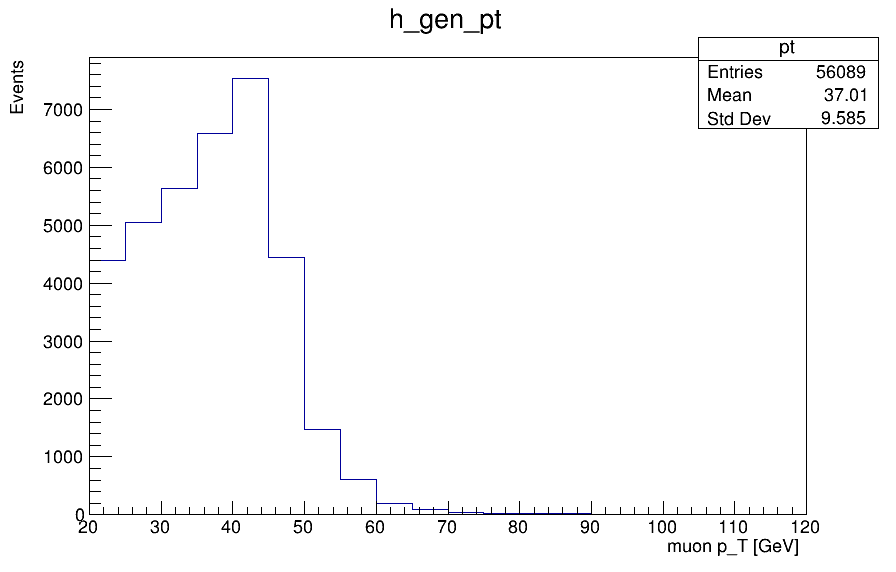

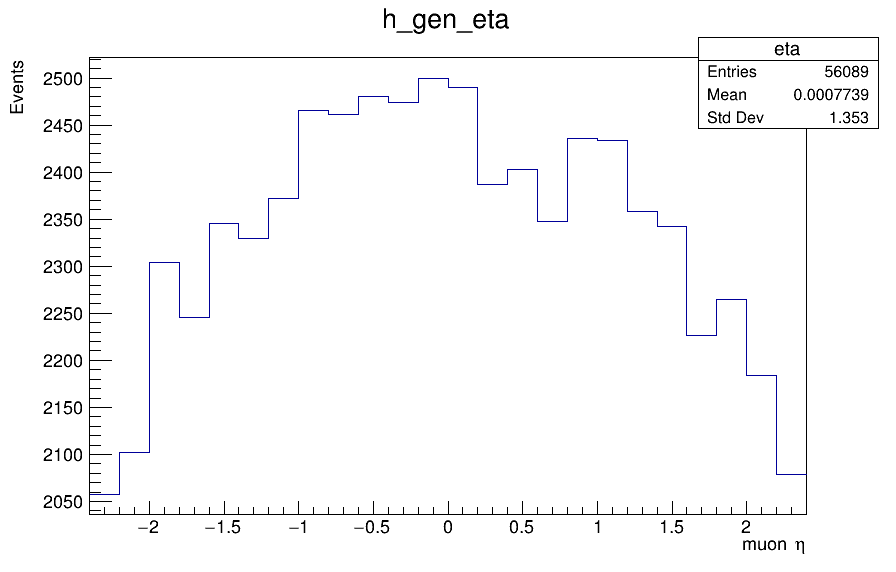

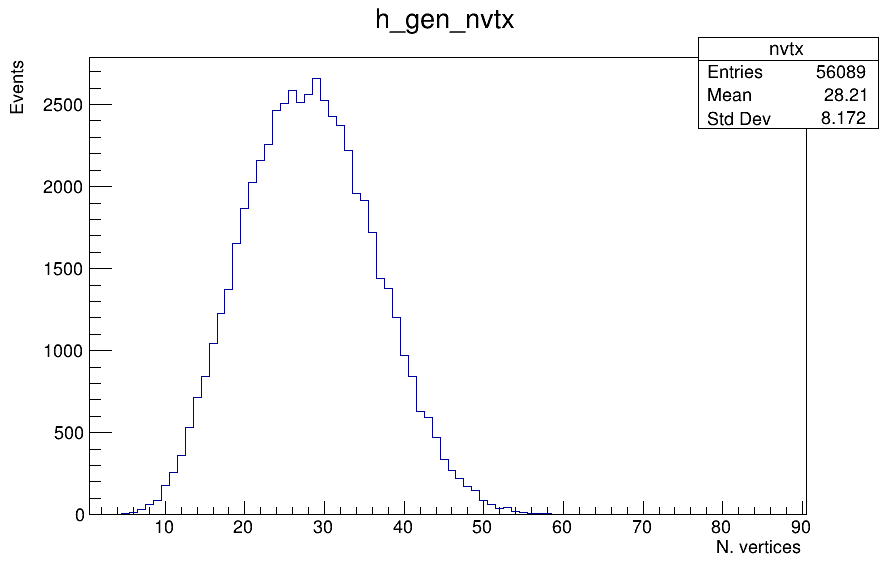

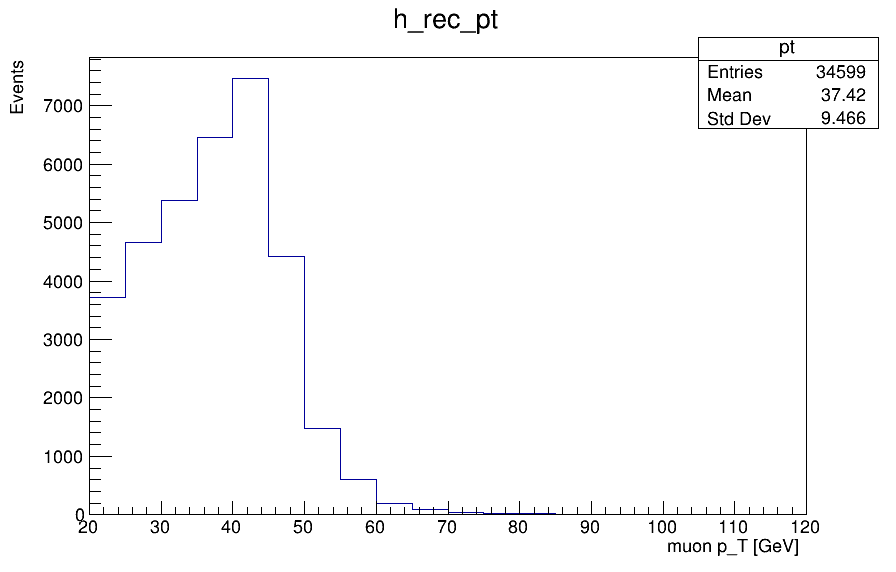

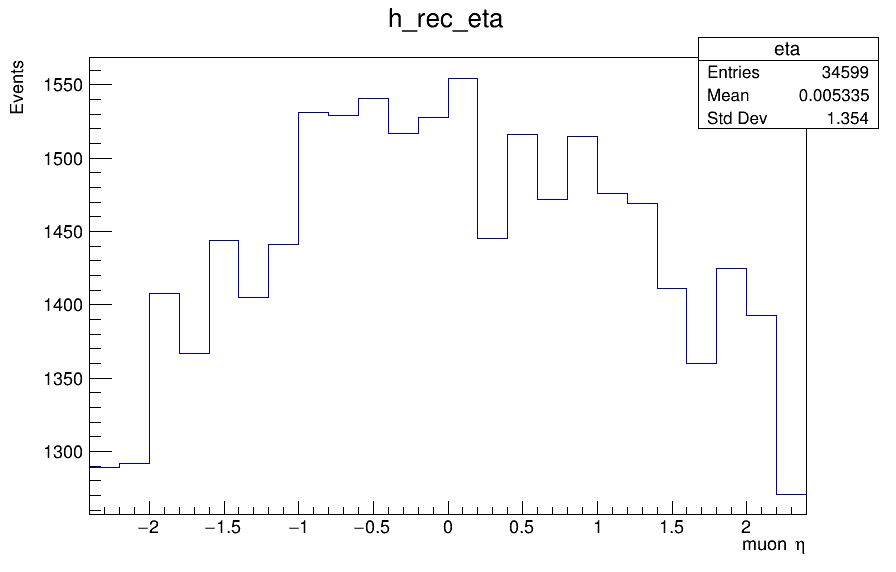

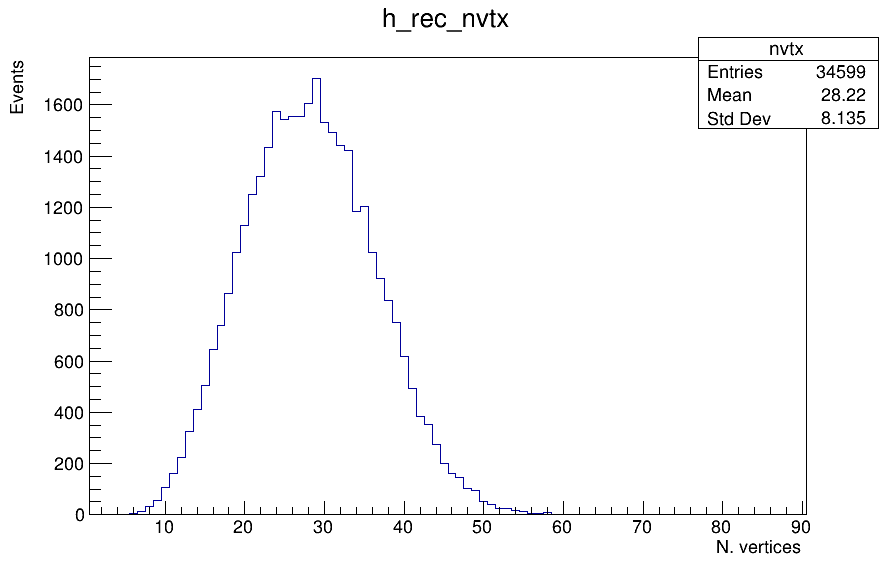

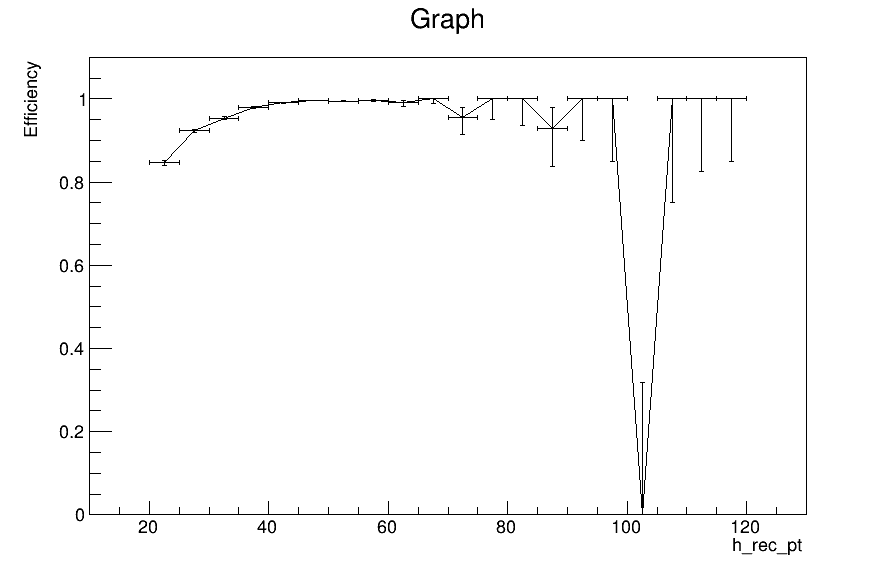

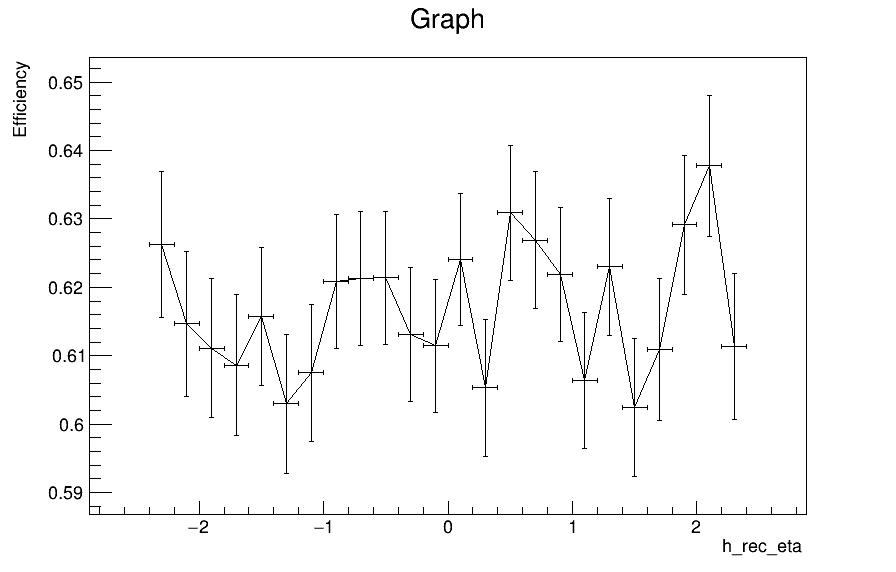

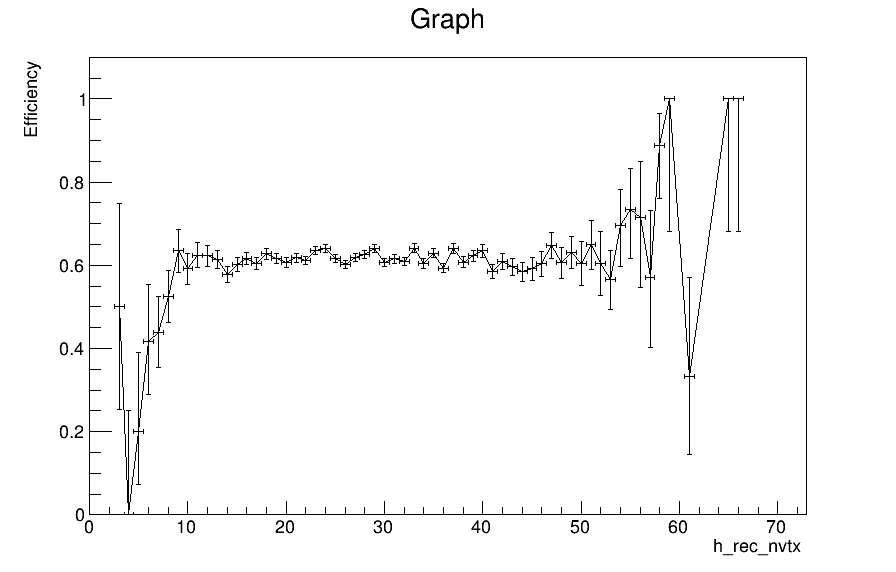

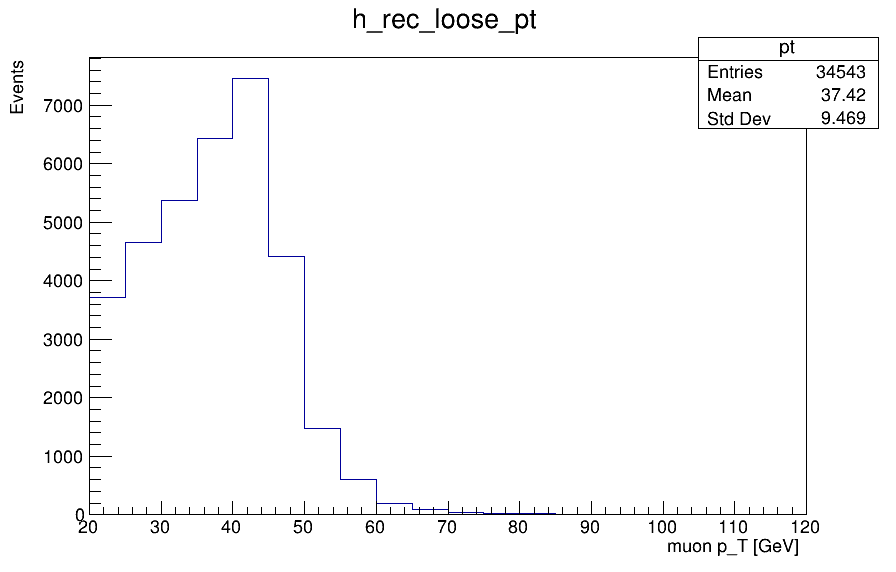

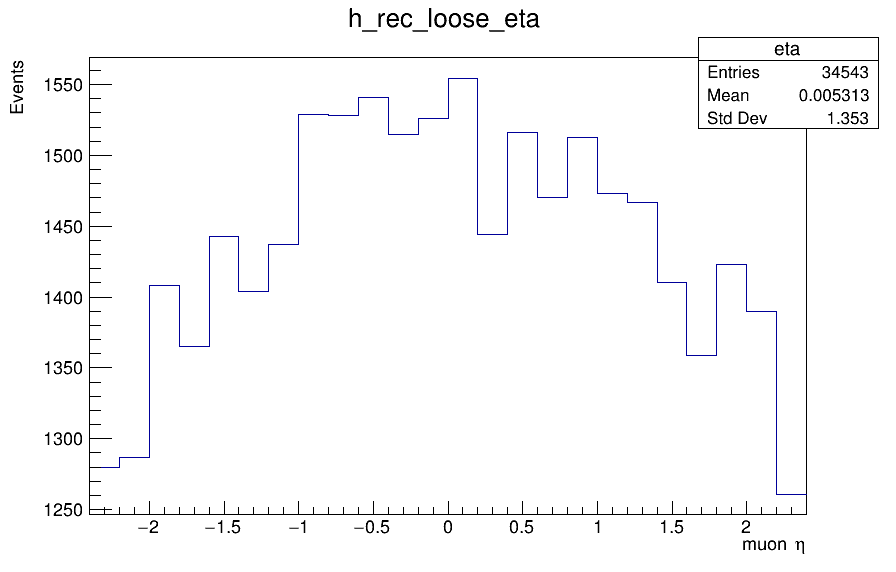

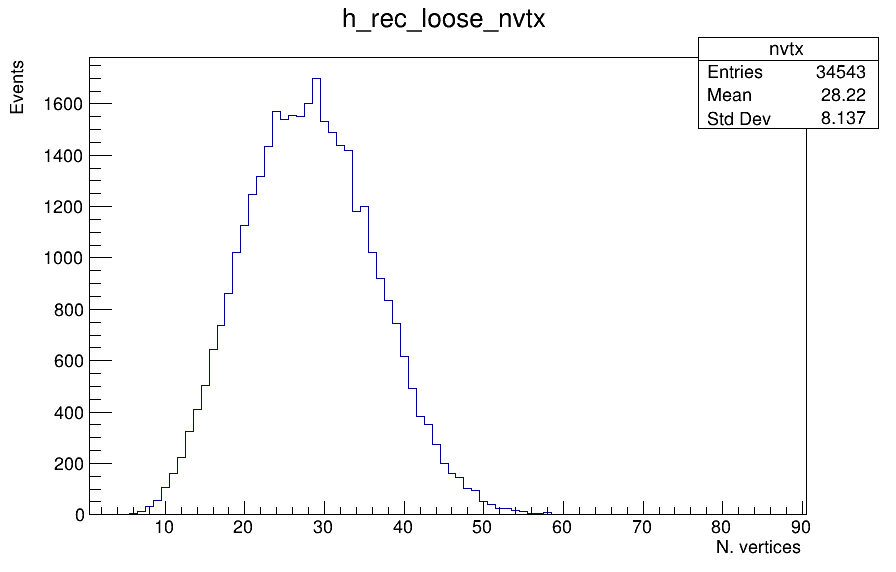

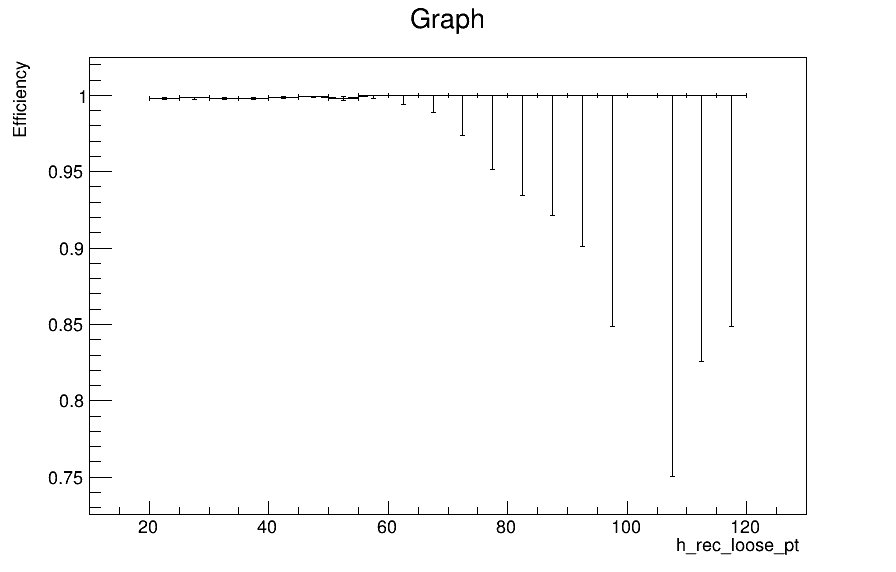

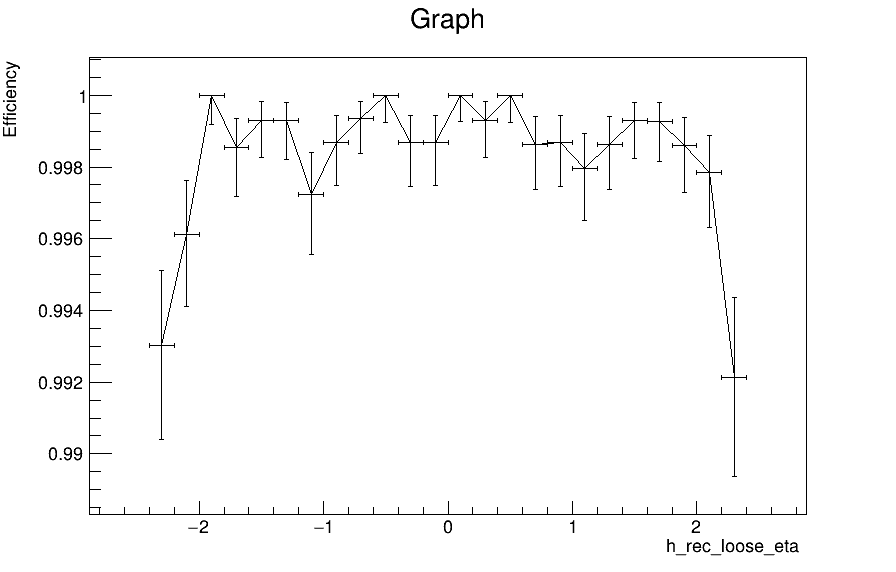

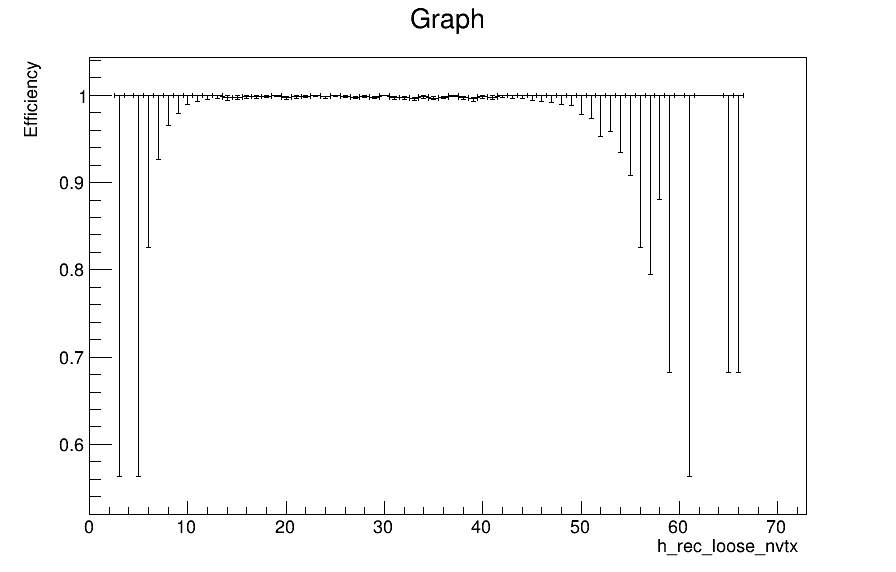

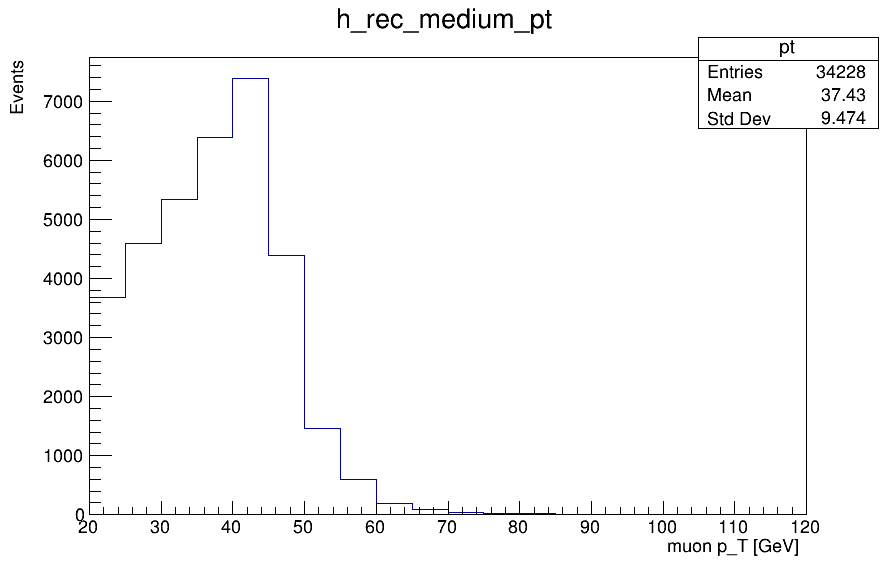

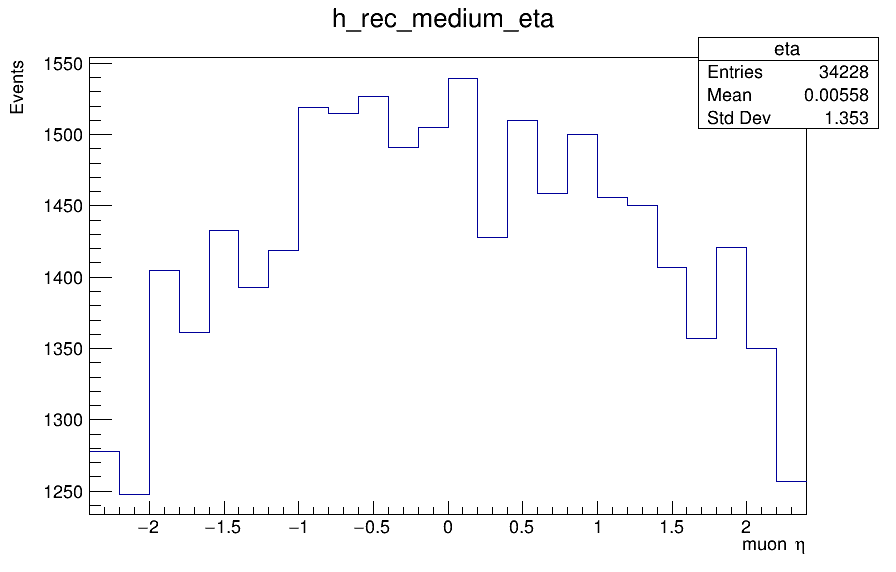

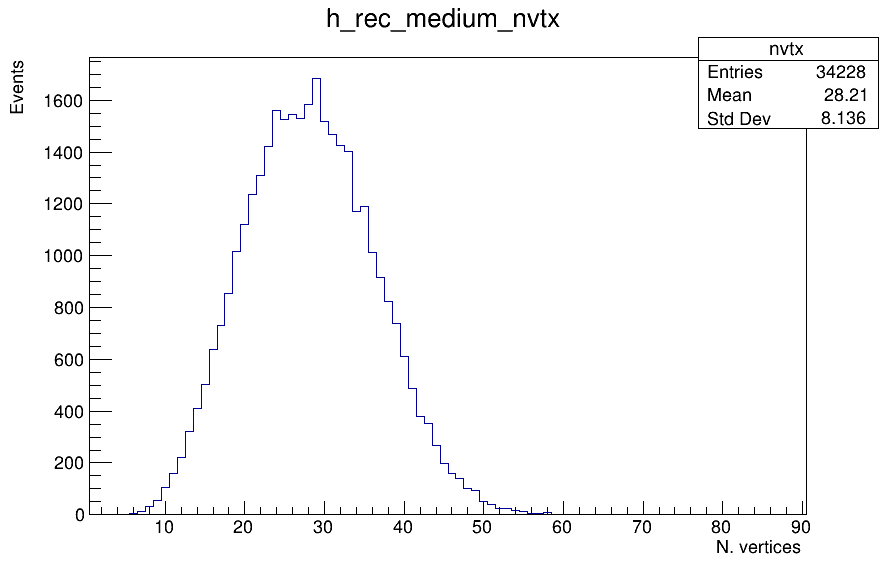

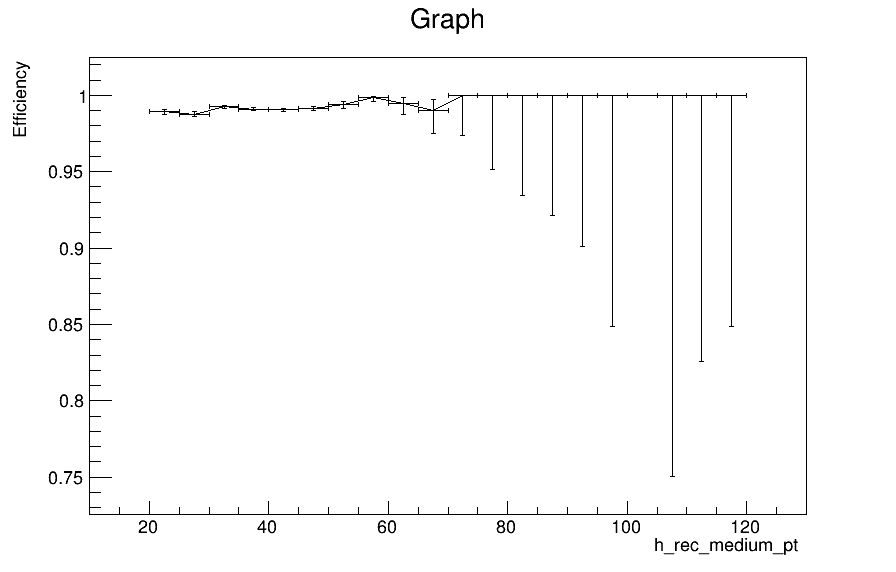

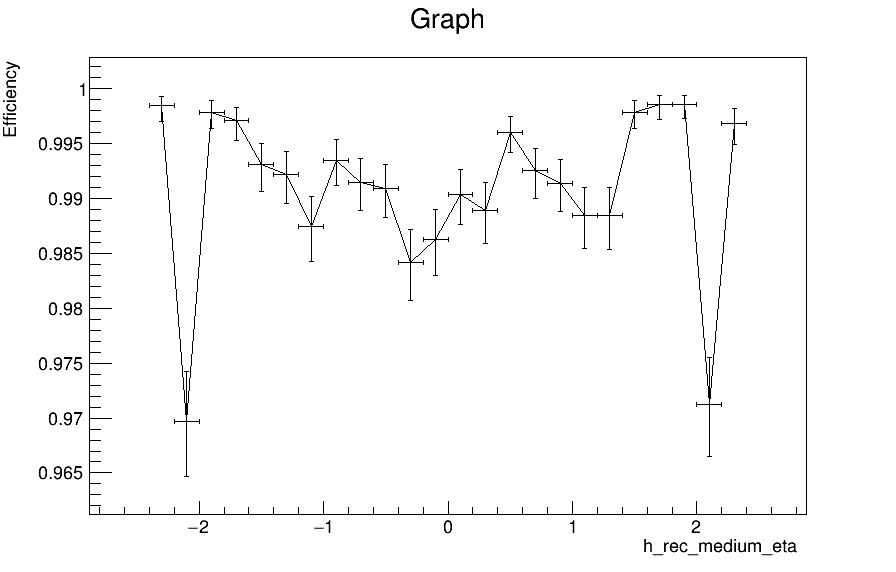

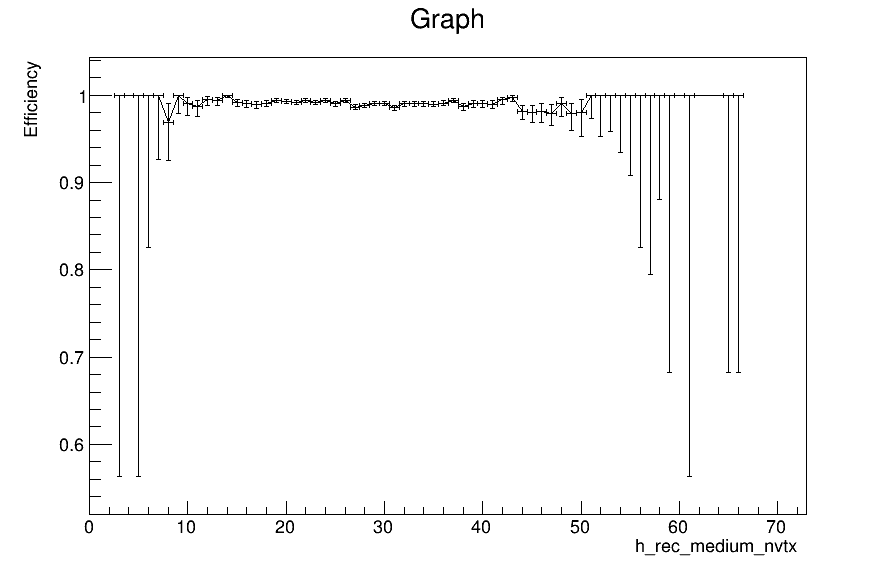

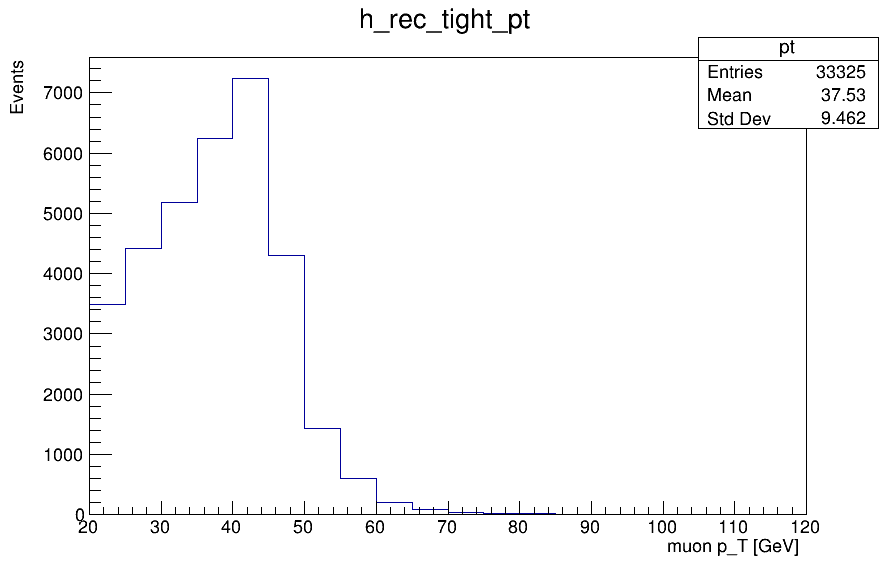

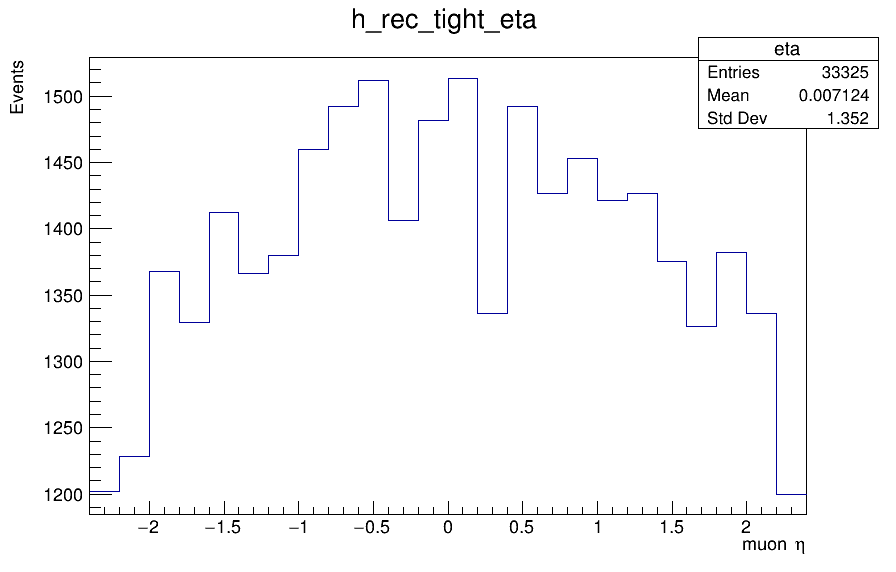

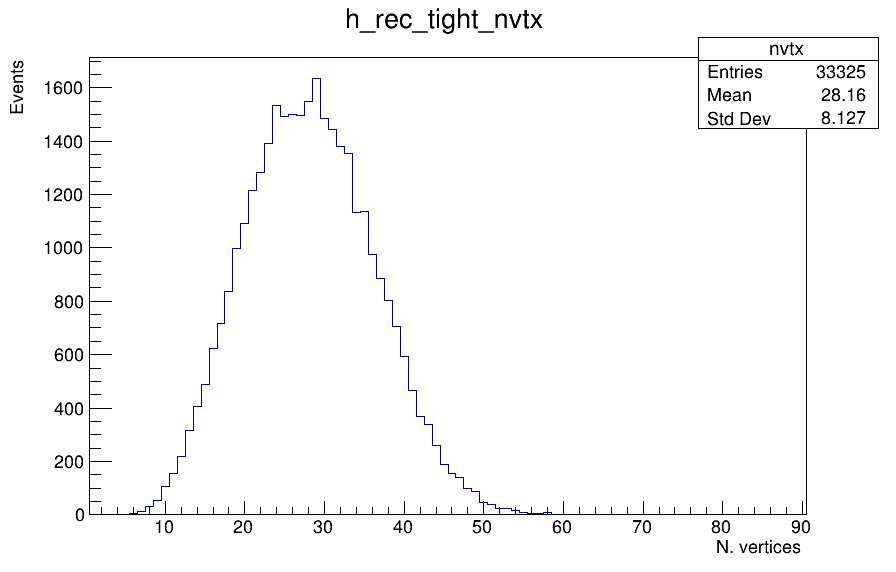

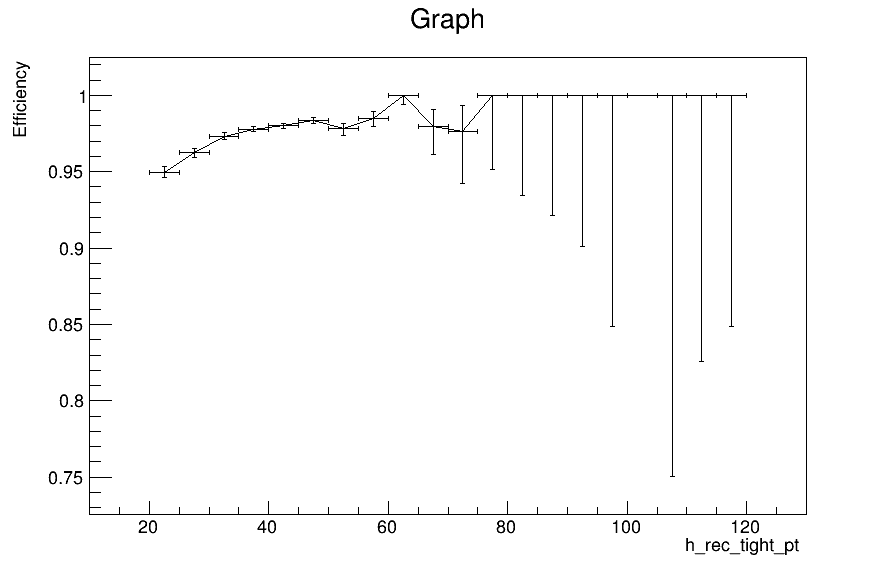

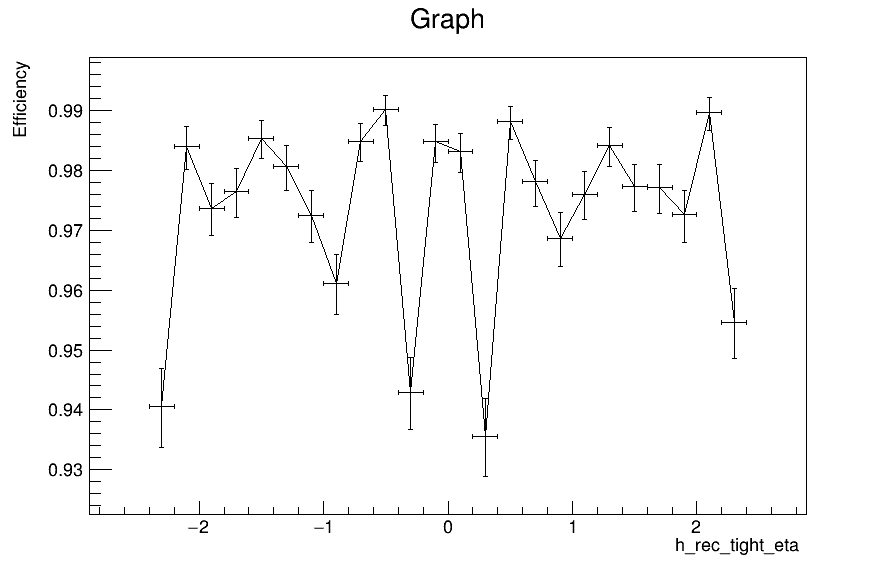

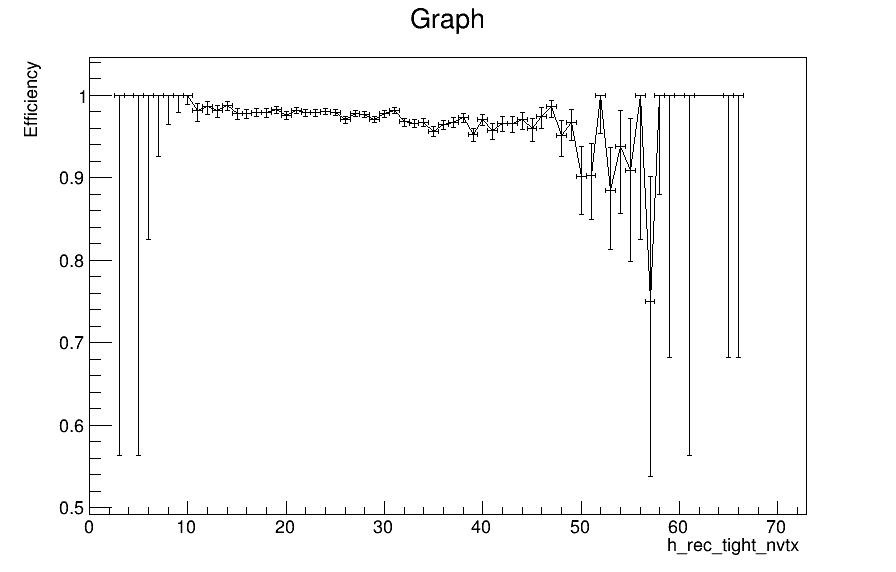

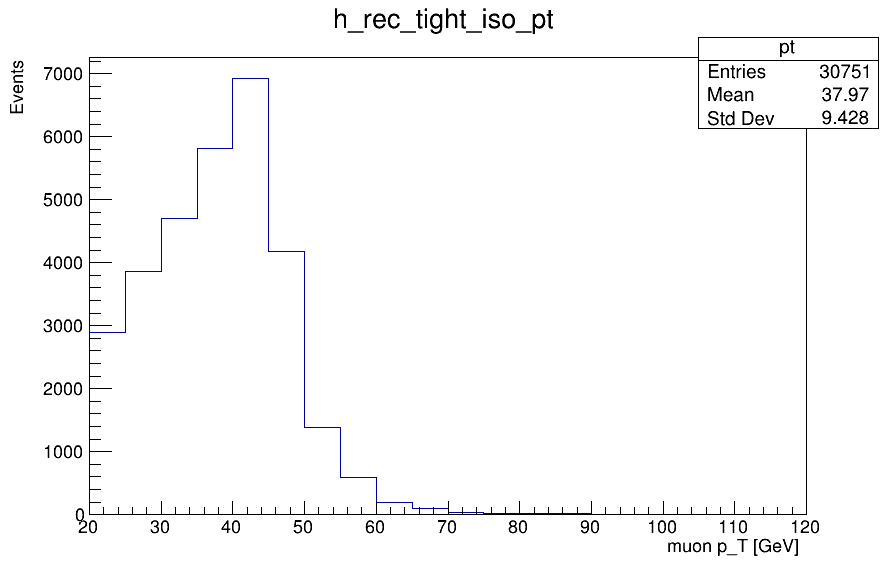

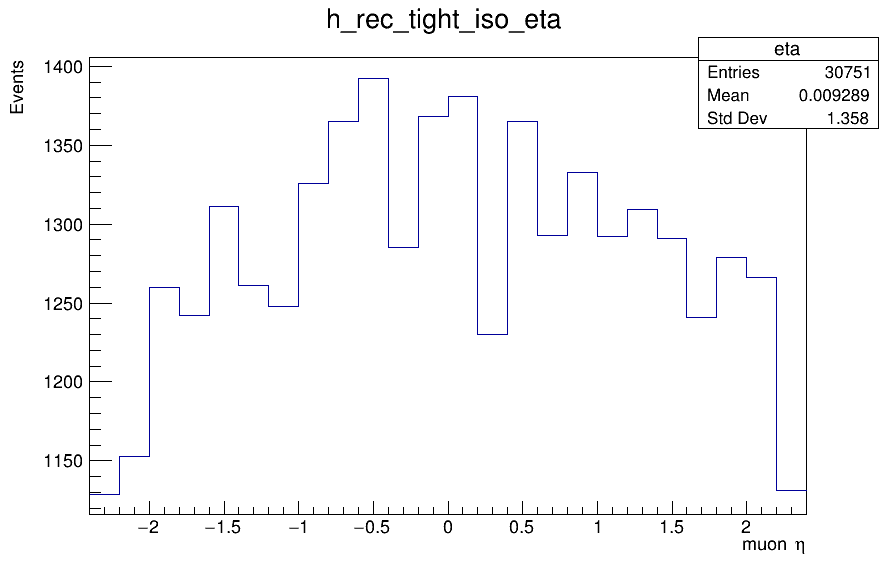

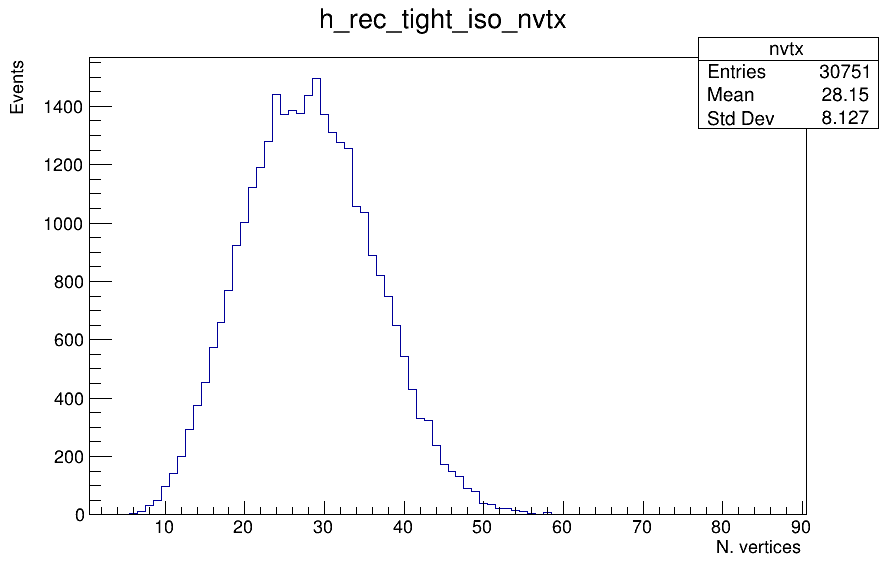

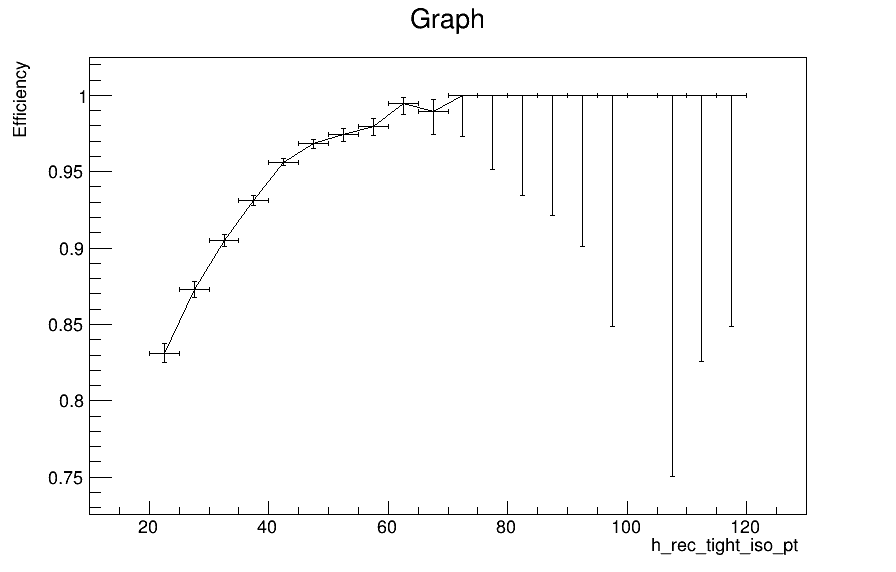

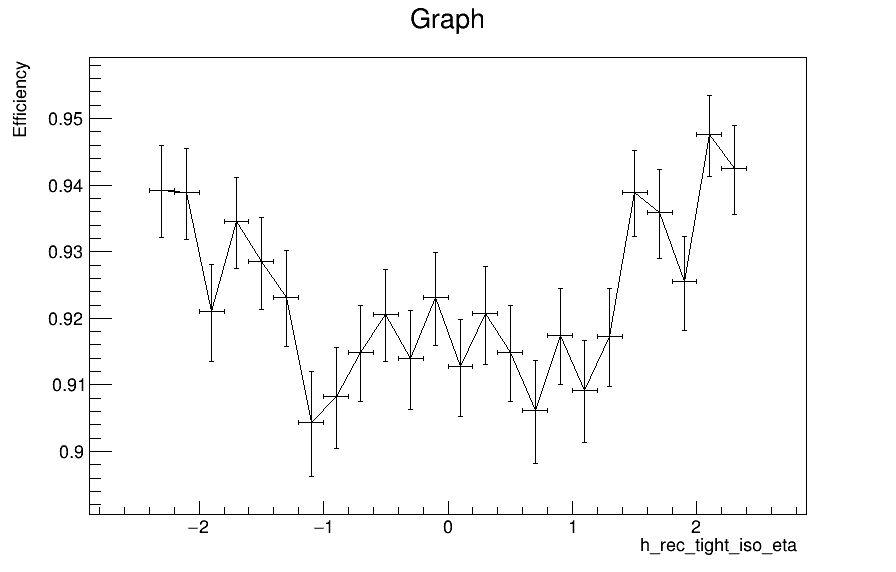

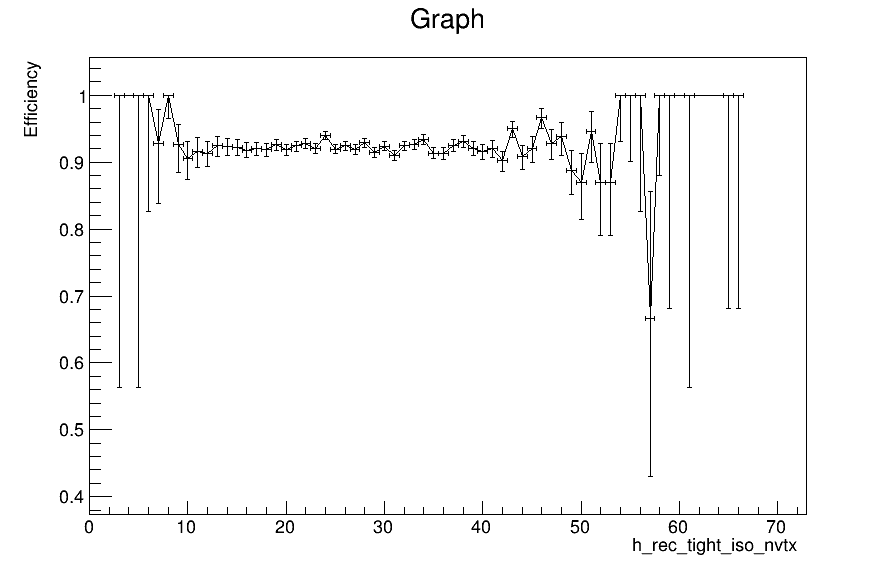

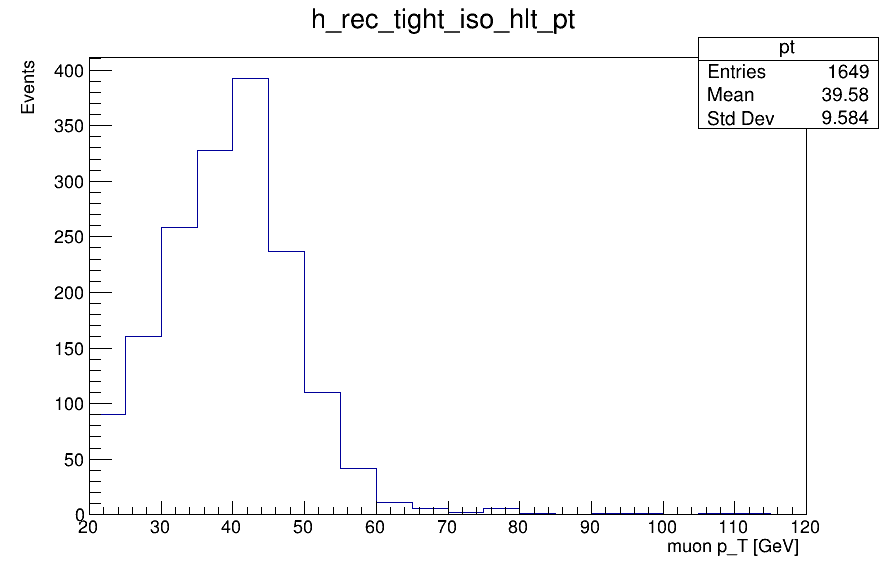

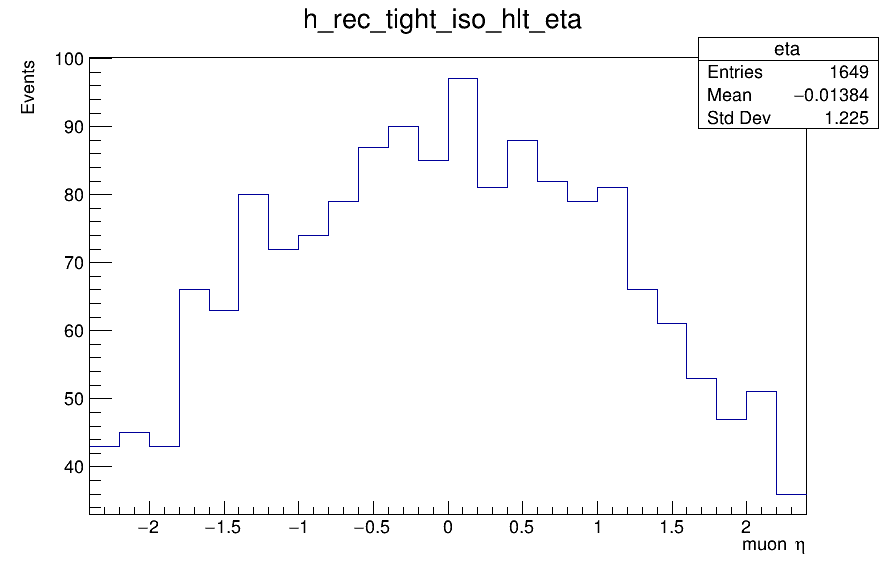

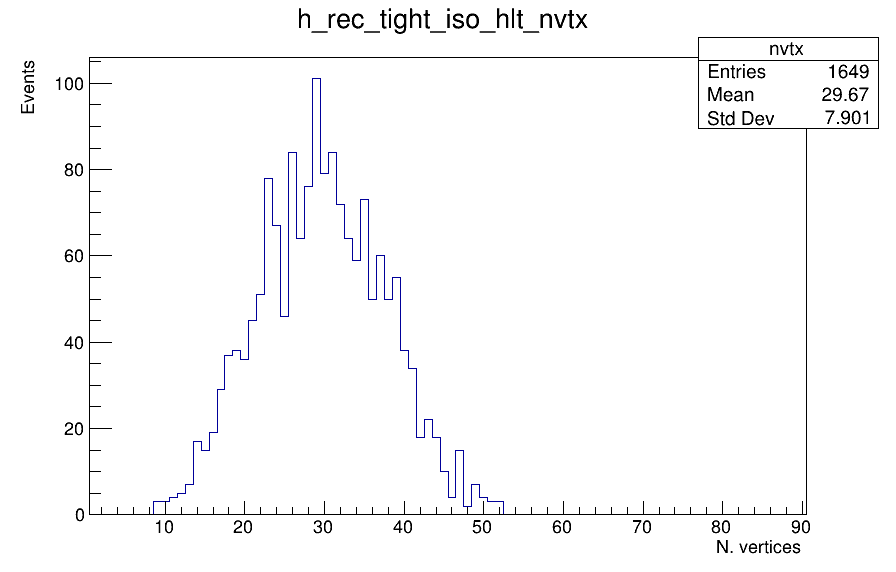

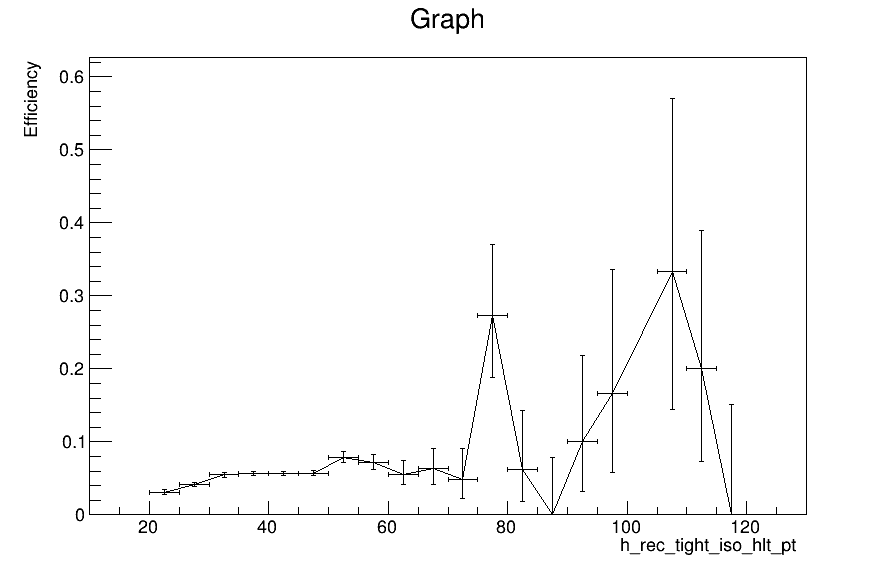

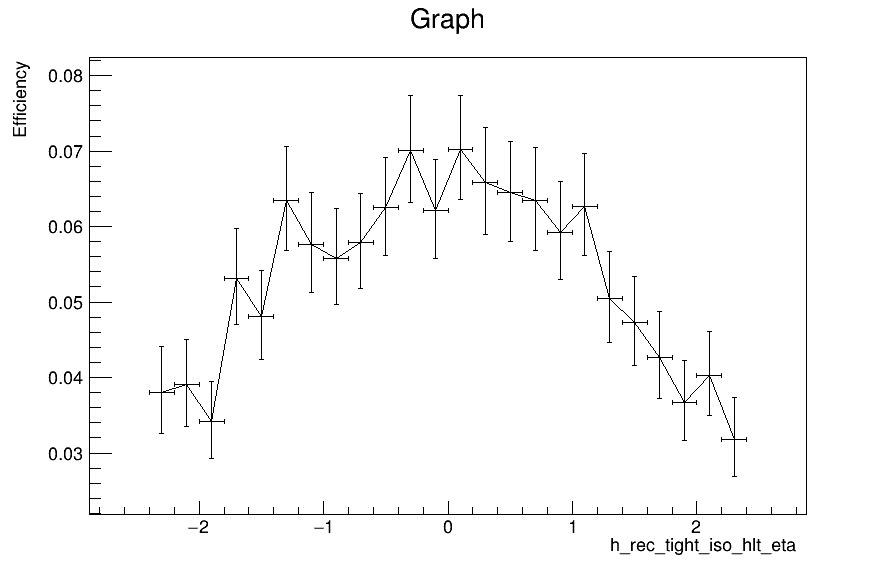

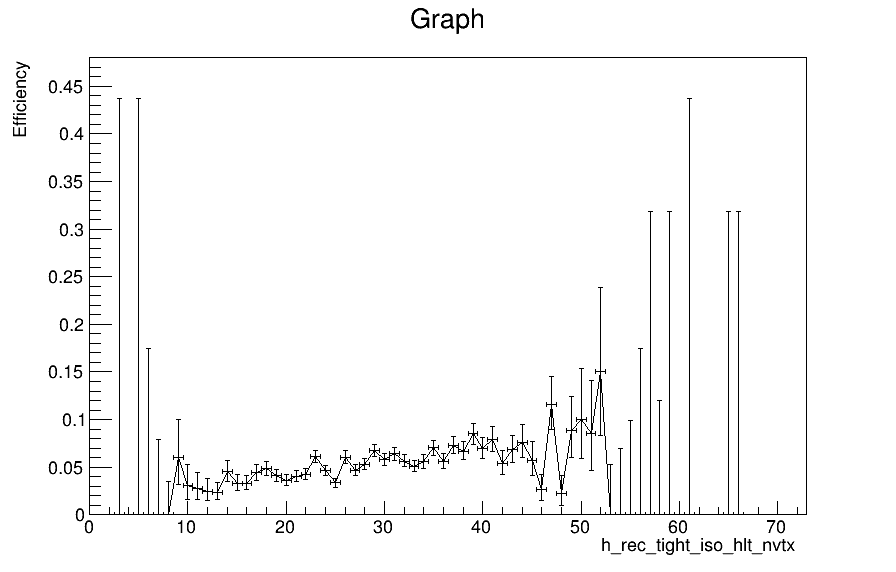

In [39]:
th1dic={} #dictionary of TH1D
efficiencydic={} #dictionary of TGraphAsymmErrors
for name in ['gen', 'rec', 'rec_loose', 'rec_medium', 'rec_tight', 'rec_tight_iso', 'rec_tight_iso_hlt']:
    if name== 'gen':           #Cannot plot efficiency for gen itself, so if 
        th1dic[f'h_{name}_pt']=ROOT.TH1D("pt"  , f'h_{name}_pt;muon p_T [GeV];Events',  20,  20.0, 120.0) #constrcut
        TH1_fill_and_plot(th1dic[f'h_{name}_pt'], gen_muon.pt, f'h_{name}_pt') #fill and plot
        th1dic[f'h_{name}_eta']=ROOT.TH1D("eta" , f'h_{name}_eta;muon #eta;Events',  24,  -2.4,   2.4)
        TH1_fill_and_plot(th1dic[f'h_{name}_eta'], gen_muon.eta, f'h_{name}_eta')
        th1dic[f'h_{name}_nvtx'] =ROOT.TH1D("nvtx", f'h_{name}_nvtx;N. vertices;Events',  90,   0.5,  90.5)
        TH1_fill_and_plot(th1dic[f'h_{name}_nvtx'], gen_muon.PV_npvsGood, f'h_{name}_nvtx')
        
        name2=name
        continue
        
    if name== 'rec_tight_iso_hlt':
        print (name, name2)
        th1dic[f'h_{name}_pt']=ROOT.TH1D("pt"  , f'h_{name}_pt;muon p_T [GeV];Events',  20,  20.0, 120.0)
        TH1_fill_and_plot(th1dic[f'h_{name}_pt'], muon.matched_gen.pt[muon_mask[f'{name}']][event_mask_goodpv_HLT_isomu24], f'h_{name}_pt')
        th1dic[f'h_{name}_eta']=ROOT.TH1D("eta" , f'h_{name}_eta;muon #eta;Events',  24,  -2.4,   2.4)
        TH1_fill_and_plot(th1dic[f'h_{name}_eta'], muon.matched_gen.eta[muon_mask[f'{name}']][event_mask_goodpv_HLT_isomu24], f'h_{name}_eta')
        th1dic[f'h_{name}_nvtx'] =ROOT.TH1D("nvtx", f'h_{name}_nvtx;N. vertices;Events',  90,   0.5,  90.5)
        TH1_fill_and_plot(th1dic[f'h_{name}_nvtx'], muon.PV_npvsGood[muon_mask[f'{name}']][event_mask_goodpv_HLT_isomu24], f'h_{name}_nvtx')

        efficiencydic[f'gae_{name}_pt']   = ROOT.TGraphAsymmErrors(20) 
        efficiencydic[f'gae_{name}_pt'].SetName(f'gae_{name}_pt')
        efficiencydic[f'gae_{name}_pt'].GetXaxis().SetTitle(f'h_{name}_pt')
        efficiencydic[f'gae_{name}_pt'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_pt'].Divide(th1dic[f'h_{name}_pt']  , th1dic[f'h_{name2}_pt']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_pt'], f'gae_{name}_pt')
        
        efficiencydic[f'gae_{name}_eta']   = ROOT.TGraphAsymmErrors(24 ) 
        efficiencydic[f'gae_{name}_eta'].SetName(f'gae_{name}_eta')
        efficiencydic[f'gae_{name}_eta'].GetXaxis().SetTitle(f'h_{name}_eta')
        efficiencydic[f'gae_{name}_eta'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_eta'].Divide(th1dic[f'h_{name}_eta']  , th1dic[f'h_{name2}_eta']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_eta'], f'gae_{name}_eta')
        
        efficiencydic[f'gae_{name}_nvtx']   = ROOT.TGraphAsymmErrors(90 ) 
        efficiencydic[f'gae_{name}_nvtx'].SetName(f'gae_{name}_nvtx')
        efficiencydic[f'gae_{name}_nvtx'].GetXaxis().SetTitle(f'h_{name}_nvtx')
        efficiencydic[f'gae_{name}_nvtx'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_nvtx'].Divide(th1dic[f'h_{name}_nvtx']  , th1dic[f'h_{name2}_nvtx']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_nvtx'], f'gae_{name}_nvtx')
        
        name2=name
    else:
        th1dic[f'h_{name}_pt']=ROOT.TH1D("pt"  , f'h_{name}_pt;muon p_T [GeV];Events',  20,  20.0, 120.0)
        TH1_fill_and_plot(th1dic[f'h_{name}_pt'], muon.matched_gen.pt[muon_mask[f'{name}']][event_mask_goodpv], f'h_{name}_pt')
        th1dic[f'h_{name}_eta']=ROOT.TH1D("eta" , f'h_{name}_eta;muon #eta;Events',  24,  -2.4,   2.4)
        TH1_fill_and_plot(th1dic[f'h_{name}_eta'], muon.matched_gen.eta[muon_mask[f'{name}']][event_mask_goodpv], f'h_{name}_eta')
        th1dic[f'h_{name}_nvtx'] =ROOT.TH1D("nvtx", f'h_{name}_nvtx;N. vertices;Events',  90,   0.5,  90.5)
        TH1_fill_and_plot(th1dic[f'h_{name}_nvtx'], muon.PV_npvsGood[muon_mask[f'{name}']][event_mask_goodpv], f'h_{name}_nvtx')
        
        efficiencydic[f'gae_{name}_pt']   = ROOT.TGraphAsymmErrors(20 ) 
        efficiencydic[f'gae_{name}_pt'].SetName(f'gae_{name}_pt')
        efficiencydic[f'gae_{name}_pt'].GetXaxis().SetTitle(f'h_{name}_pt')
        efficiencydic[f'gae_{name}_pt'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_pt'].Divide(th1dic[f'h_{name}_pt']  , th1dic[f'h_{name2}_pt']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_pt'], f'gae_{name}_pt')
        
        efficiencydic[f'gae_{name}_eta']   = ROOT.TGraphAsymmErrors(24 ) 
        efficiencydic[f'gae_{name}_eta'].SetName(f'gae_{name}_eta')
        efficiencydic[f'gae_{name}_eta'].GetXaxis().SetTitle(f'h_{name}_eta')
        efficiencydic[f'gae_{name}_eta'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_eta'].Divide(th1dic[f'h_{name}_eta']  , th1dic[f'h_{name2}_eta']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_eta'], f'gae_{name}_eta')
        
        efficiencydic[f'gae_{name}_nvtx']   = ROOT.TGraphAsymmErrors(90 ) 
        efficiencydic[f'gae_{name}_nvtx'].SetName(f'gae_{name}_nvtx')
        efficiencydic[f'gae_{name}_nvtx'].GetXaxis().SetTitle(f'h_{name}_nvtx')
        efficiencydic[f'gae_{name}_nvtx'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_nvtx'].Divide(th1dic[f'h_{name}_nvtx']  , th1dic[f'h_{name2}_nvtx']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_nvtx'], f'gae_{name}_nvtx')
        
        name2=name



# Step 2 "Tag-and-Probe" efficiency

Note that, in this case, you will not be accessing any generator-level information. This analyzer could be used on real data

First, select the tag with the following cuts:
* Tight muon ID
* pT > 25 GeV and |η| < 2.4
* Combined relative PF isolation < 0.12 (in a cone ΔR < 0.4)
* Match a trigger object passing a single-muon trigger (e.g. HLT_IsoMu24)

Once you have found a tag, you can search for a probe. To be consistent with the previous part of the exercise, the probe should be any muon having pT > 20 GeV and |η| < 2.4 with a valid inner track. Additionally, to ensure that the tag-probe pair is compatible with a Z→μμ decay, require that tag and probe have opposite electric charges, and that their invariant mass is within a narrow window around the nominal Z mass. Since you are not performing any background subtraction here, you should choose a very narrow window, to reduce the level of background (in real data). E.g. you can choose (91 ± 5) GeV.

Once you have found both a tag and a probe, you can proceed to fill the plots using the probe information, at different stages of probe selection. Make the same plots as in Part 1, starting from the reconstructed muons with a valid track, obviously you don't have a collection of "all the generated muons" in this case! Create the efficiency TGraphAsymmErrors as in Part 1, starting from the ID efficiencies.

Finally, run the code and compare the tag-and-probe efficiencies with the MC-truth efficiencies.

In [40]:
tag_muon_mask=(muon.pt>25)& (abs(muon.eta)<2.4)& (muon.tightId==1)& (muon.dz<0.1)& (muon.pfRelIso04_all< 0.12)& trigger_match_mask

In [41]:
tag_muon=muon[tag_muon_mask]

In [42]:
probe_muon_mask=[]
# make sure the z mass is within 91+-5 window
for tag4s, probe4s, in zip(tag_muon, muon):
    list=[]
    if len(probe4s)==0:
        probe_muon_mask.append([])
        continue
    for probe4 in probe4s:
        bestmass=0
        if len(tag4s)==0:
            list.append(False)
            continue
        for tag4 in tag4s:
            if tag4.charge*probe4.charge>0:
                continue
            mass=sqrt(2*tag4.pt*probe4.pt*(cosh(tag4.eta - probe4.eta) - cos(tag4.phi - probe4.phi)))
            if abs(mass-91.)>5.:
                continue
            else:
                bestmass= mass
                break
        if bestmass!=0:
            list.append(True)
        else:
            list.append(False)
    probe_muon_mask.append(list)
            
            

In [43]:
probe_muon_masking=ak.from_iter(probe_muon_mask)& (muon.pt>20)& (abs(muon.eta)<2.4)

In [44]:
probe_muon= muon[probe_muon_masking]

In [45]:
muon_mask={}
muon_mask['rec']= probe_muon_masking
muon_mask['rec_loose']= probe_muon_masking& (muon.looseId==1) 
muon_mask['rec_medium']= probe_muon_masking& (muon.mediumId==1) 
muon_mask['rec_tight']=  probe_muon_masking& (muon.tightId==1)
muon_mask['rec_tight_iso']= probe_muon_masking& (muon.tightId==1)& (muon.pfRelIso04_all< 0.12)
muon_mask['rec_tight_iso_hlt']= probe_muon_masking& (muon.tightId==1)& (muon.pfRelIso04_all< 0.12)& trigger_match_mask

Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_rec_pt
Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_rec_eta
Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_rec_nvtx
Warning in <TROOT::Append>: Replacing existing TH1: pt (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_rec_loose_pt
Warning in <TROOT::Append>: Replacing existing TH1: eta (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_rec_loose_eta
Warning in <TROOT::Append>: Replacing existing TH1: nvtx (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_rec_loose_nvtx
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 9 points have been skipped
Warning in <TCanvas::Constructor>: Deleting canvas with same name: gae_rec_loose_pt
Warning in <TCanvas::Constructor>: Deleting canvas with same name: g

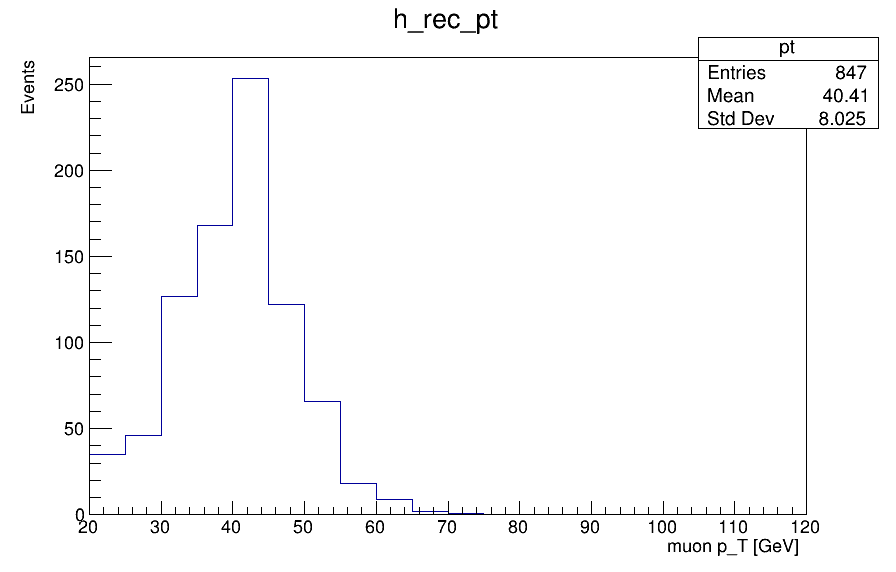

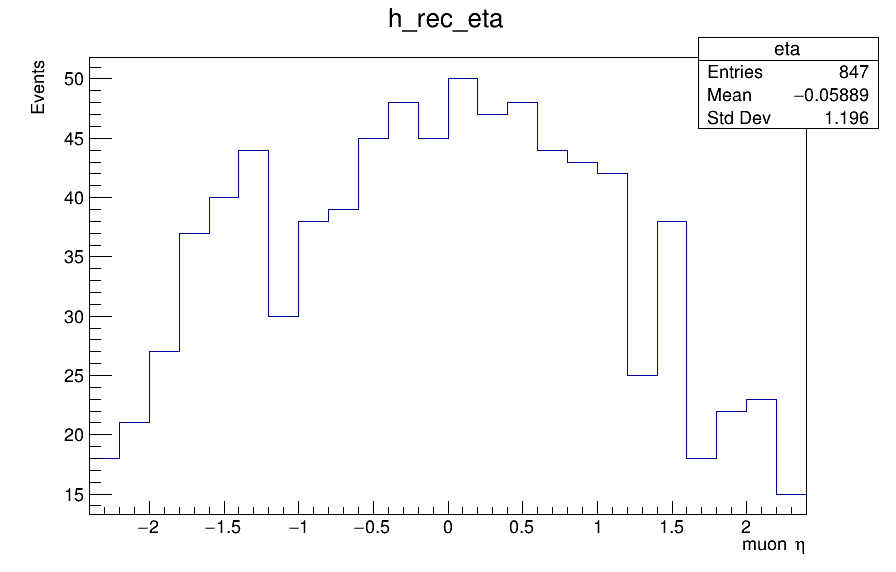

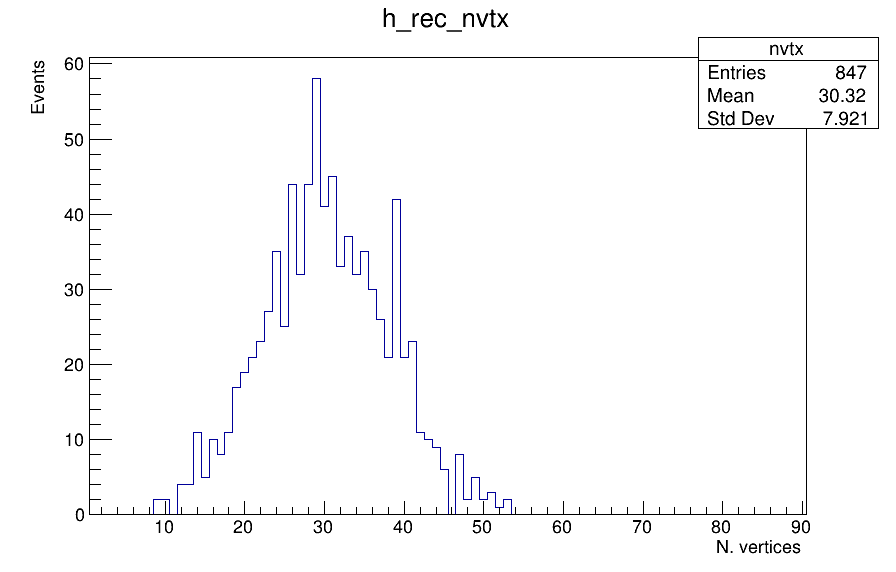

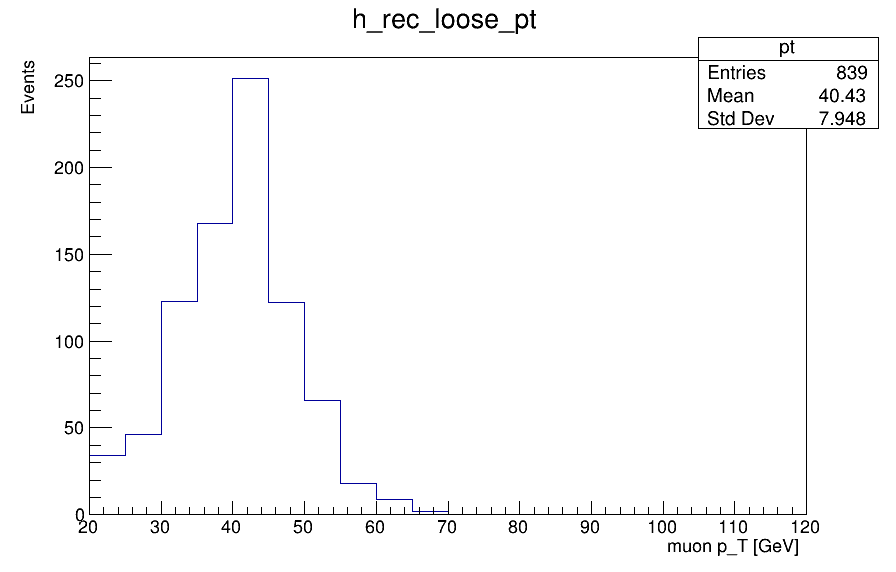

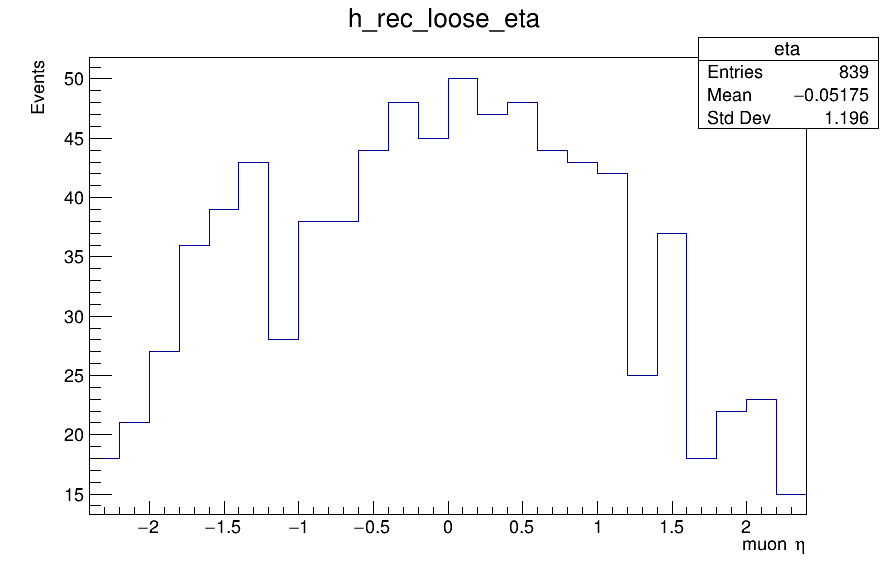

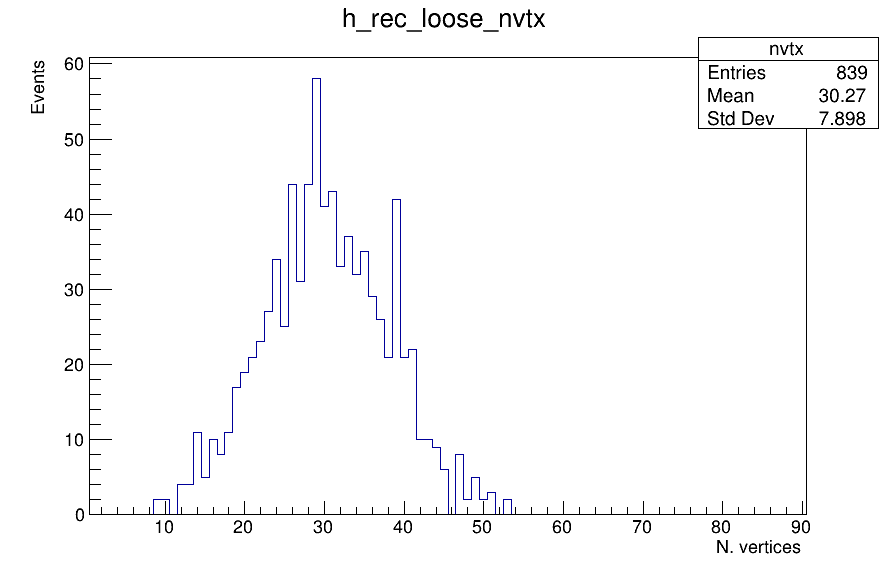

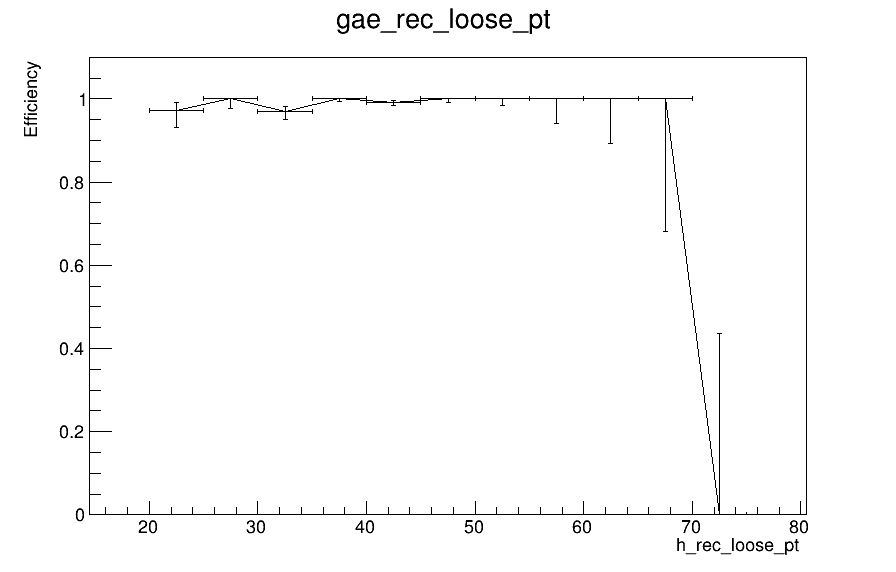

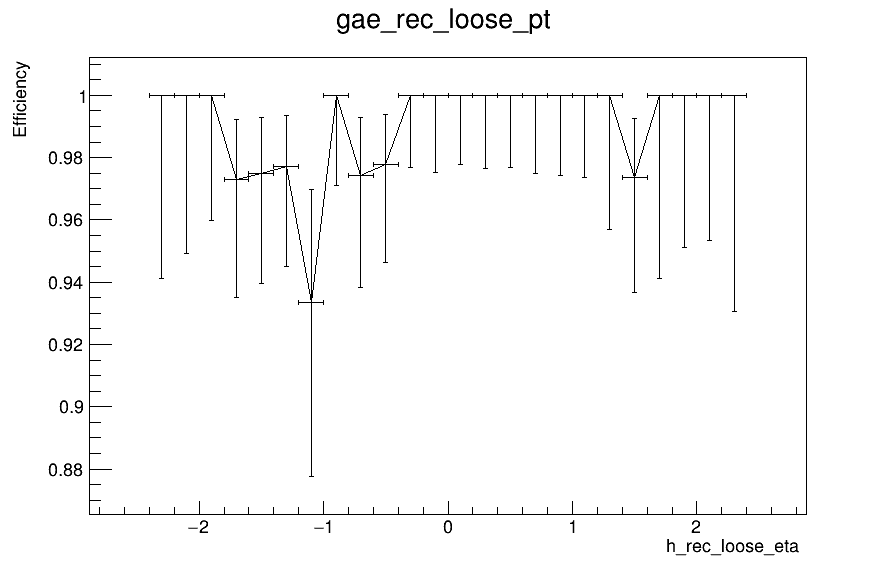

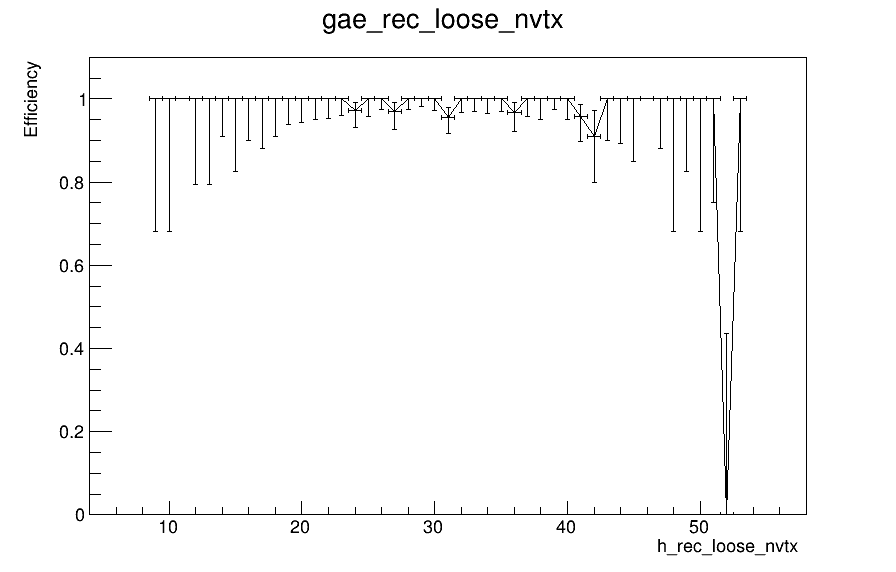

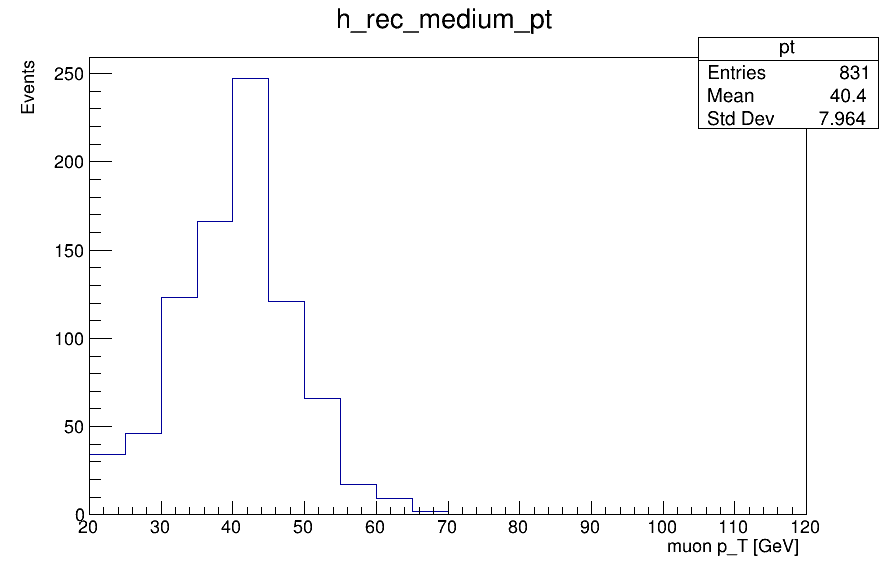

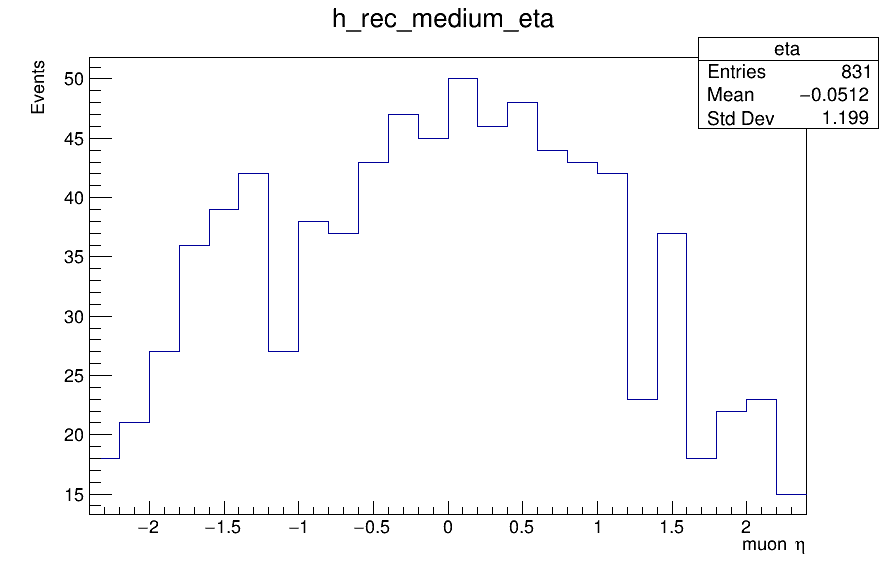

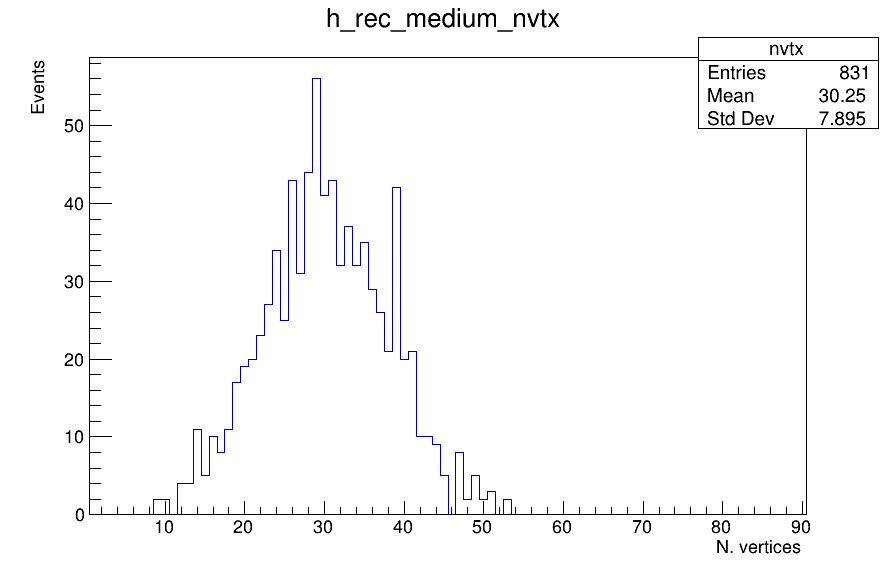

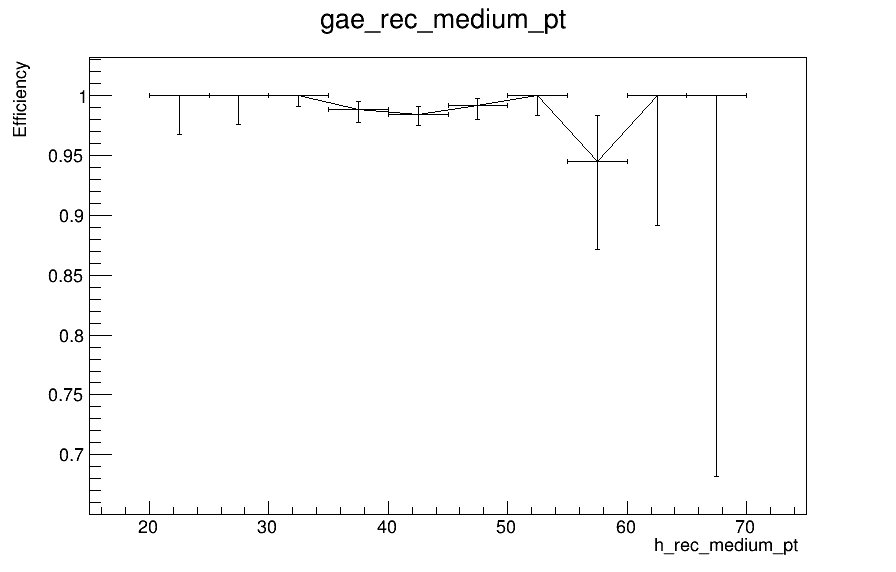

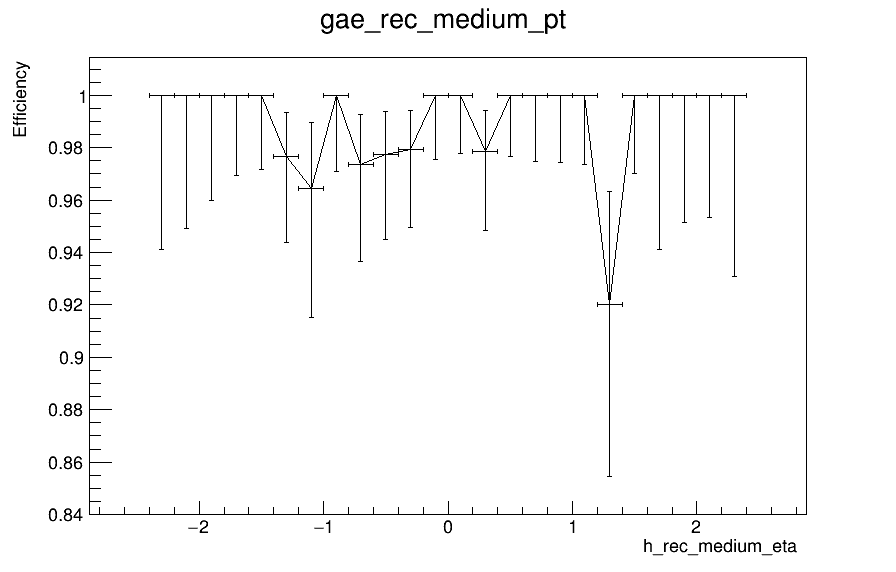

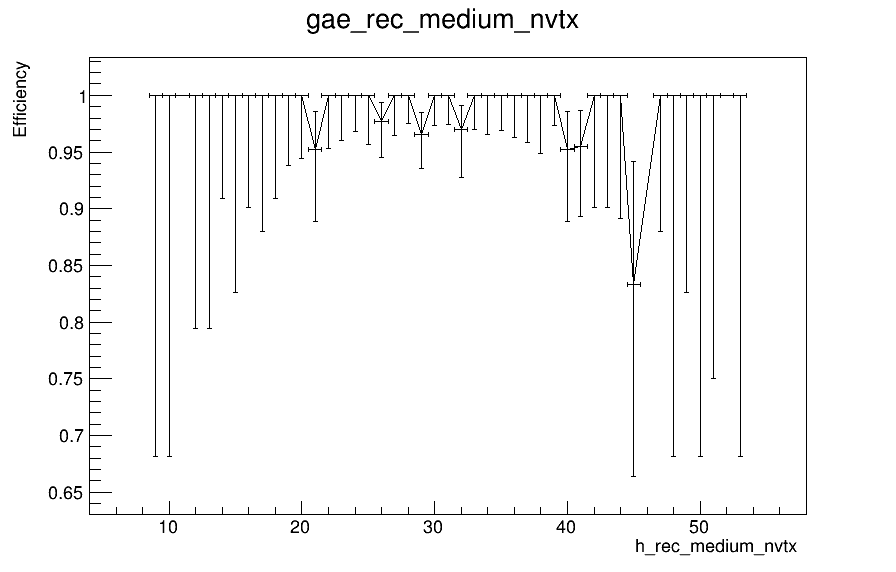

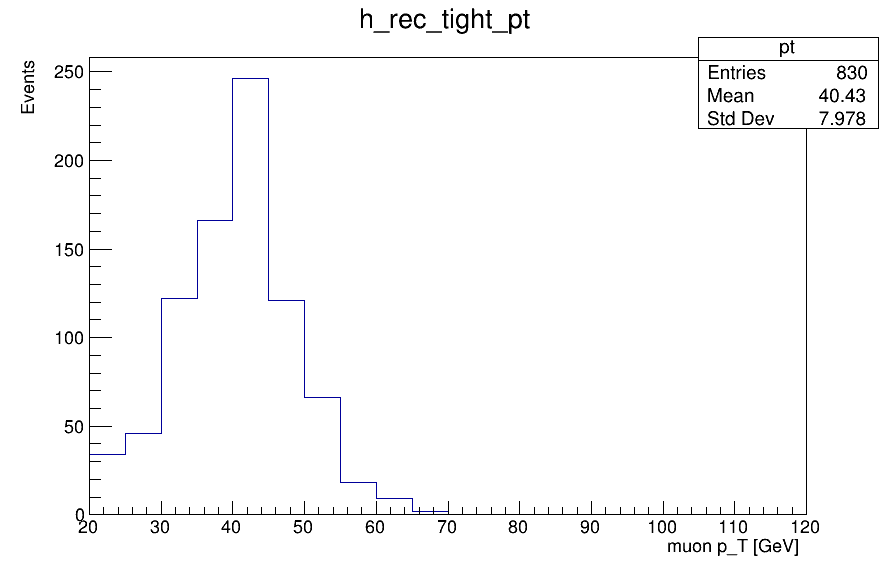

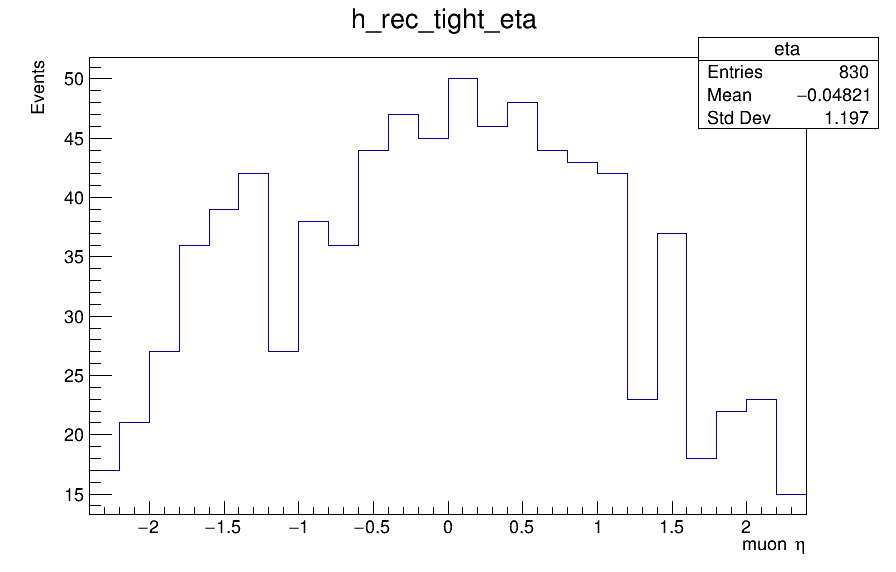

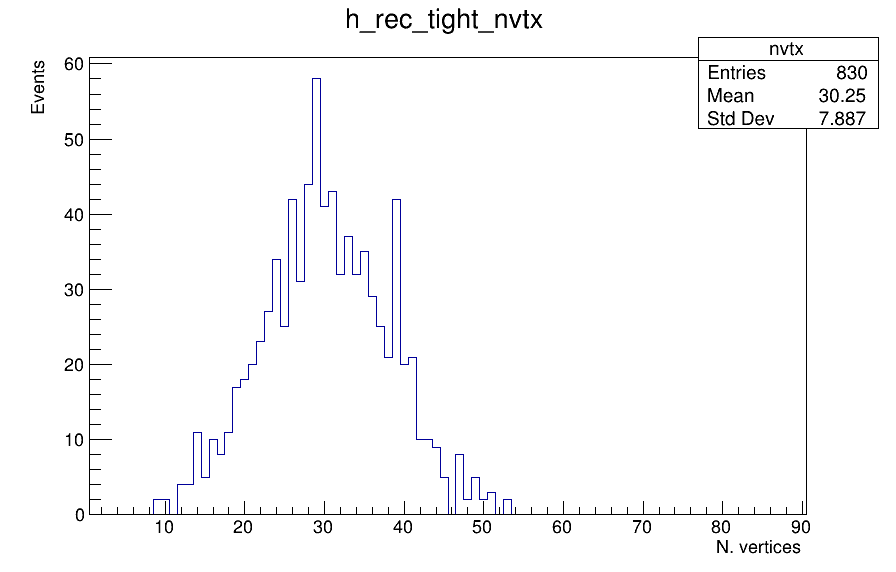

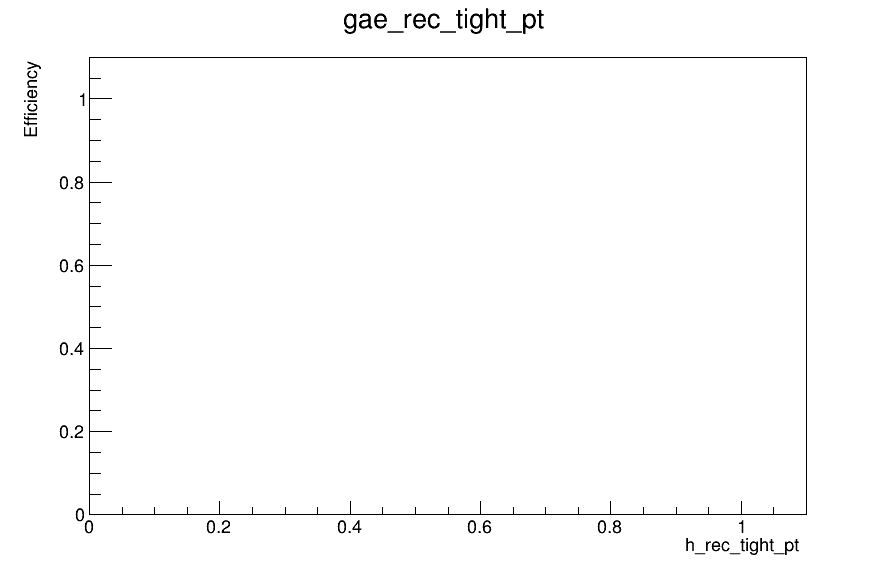

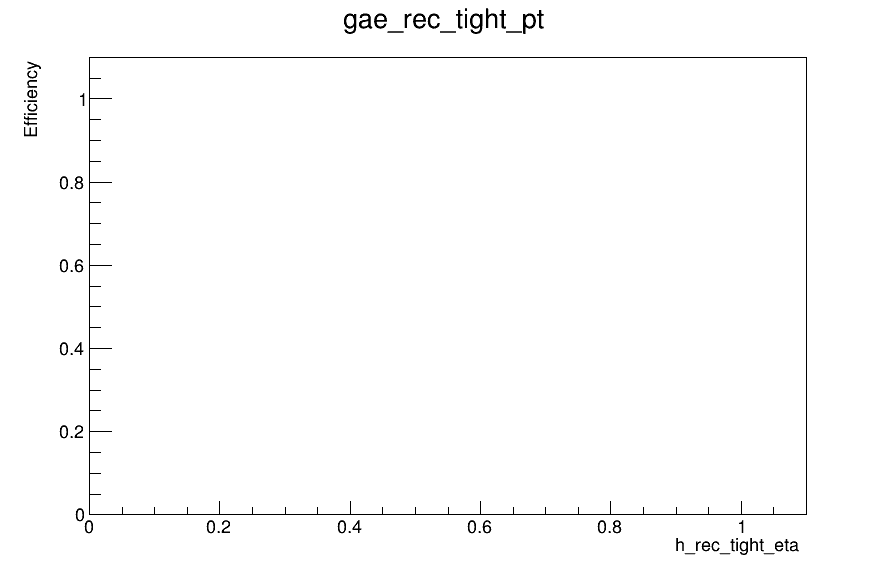

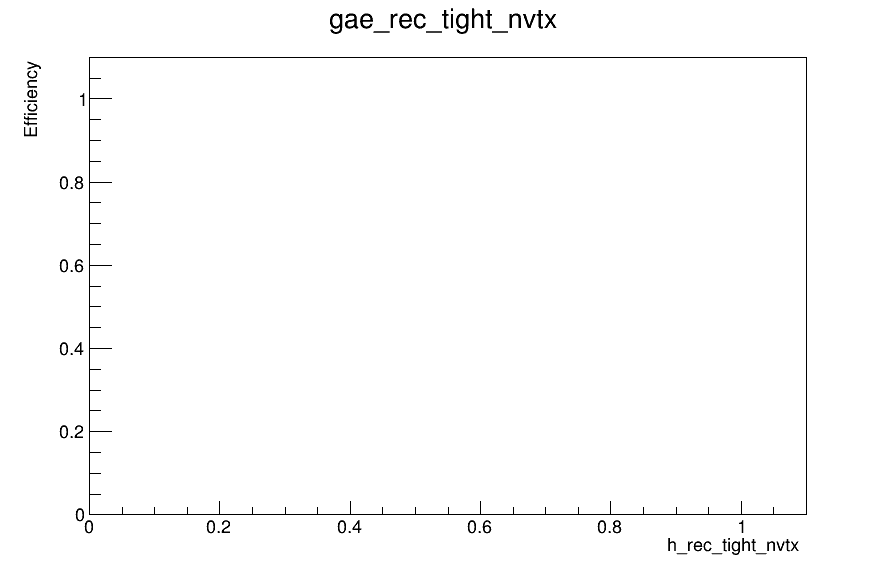

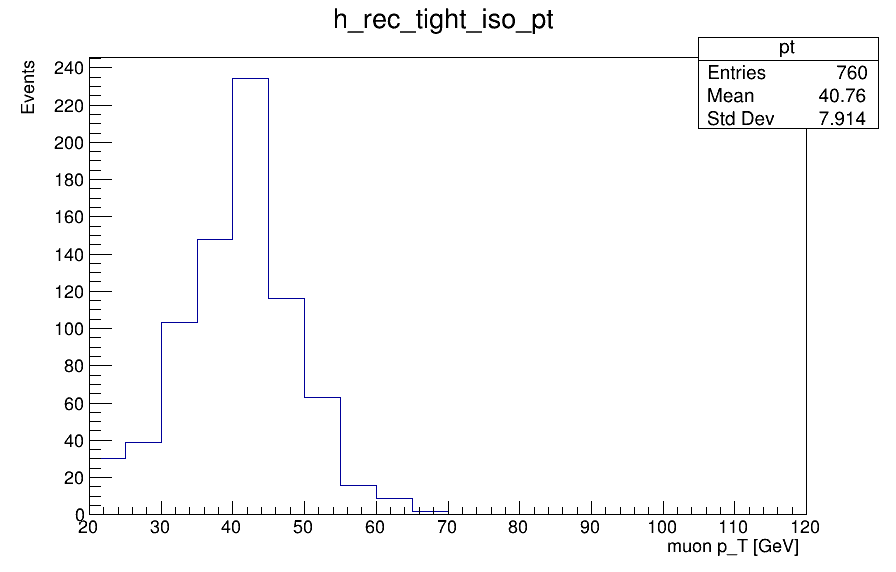

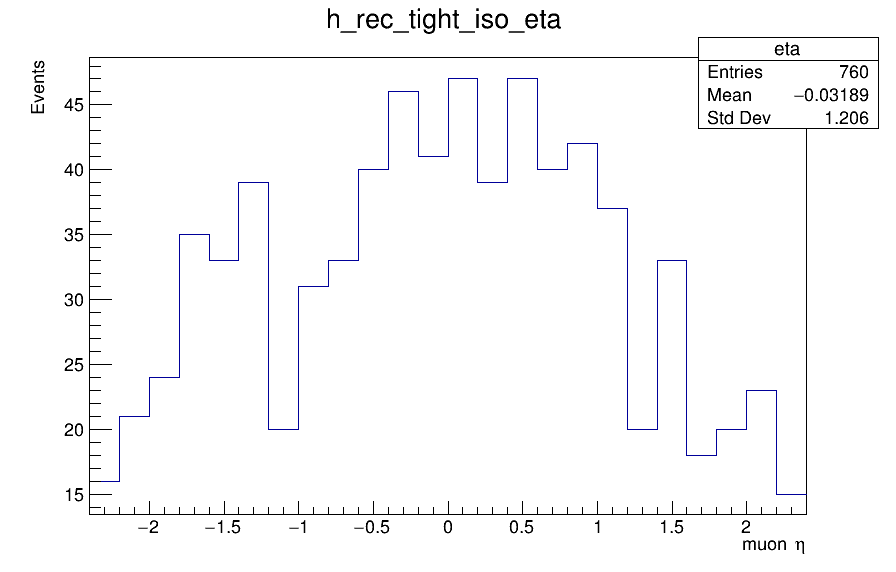

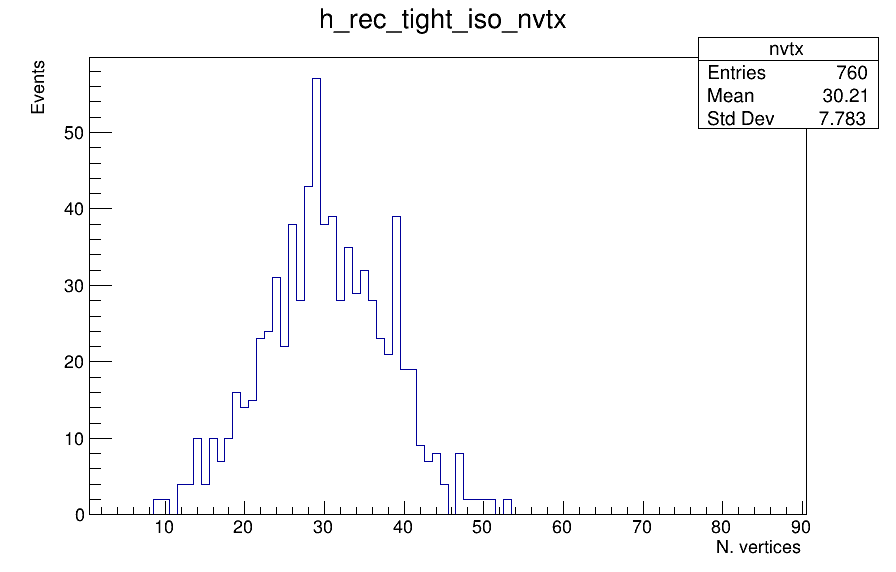

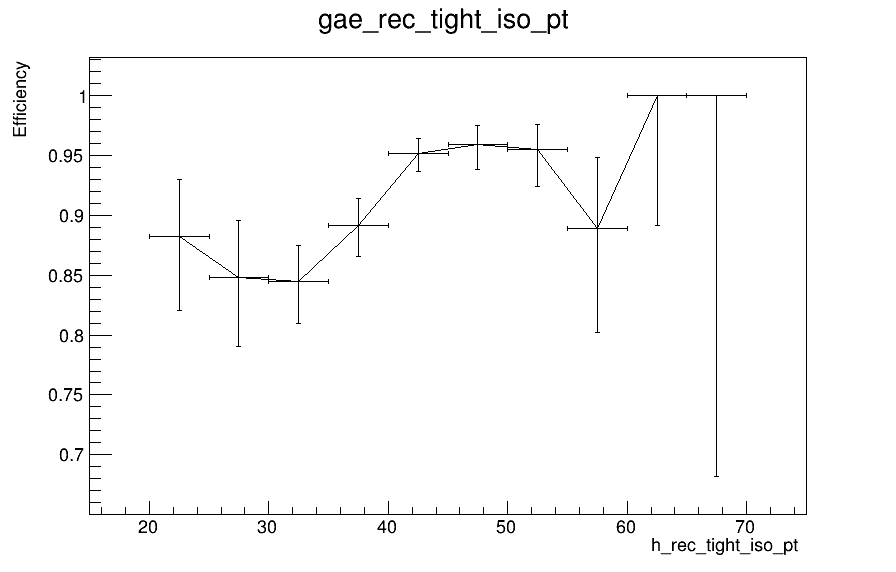

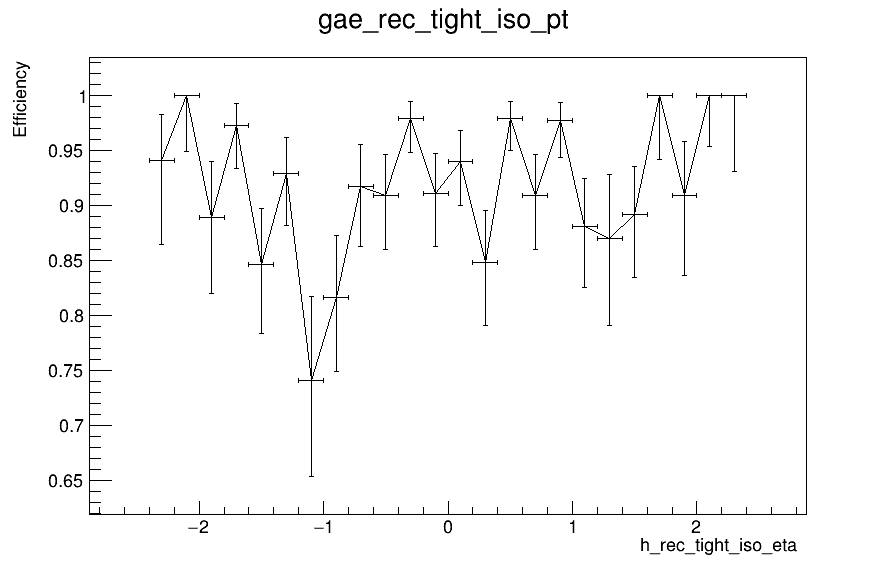

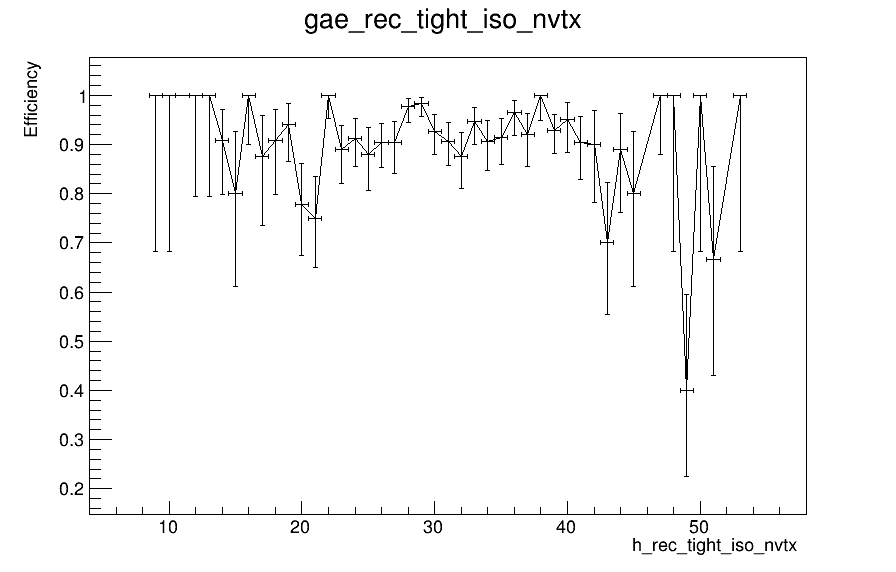

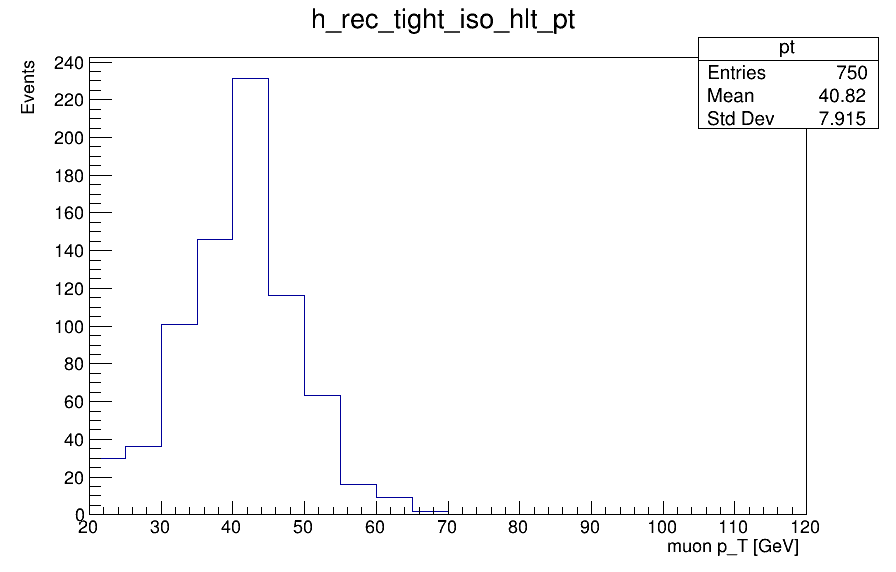

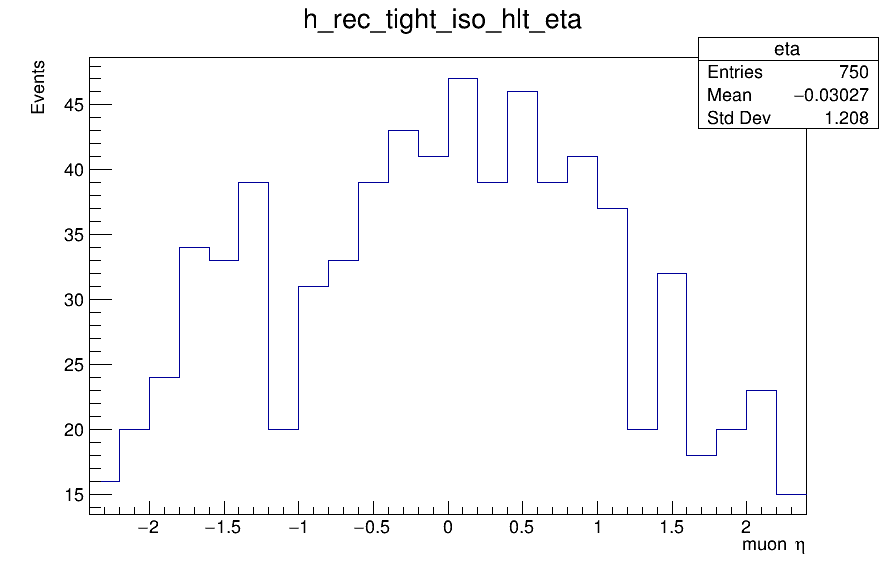

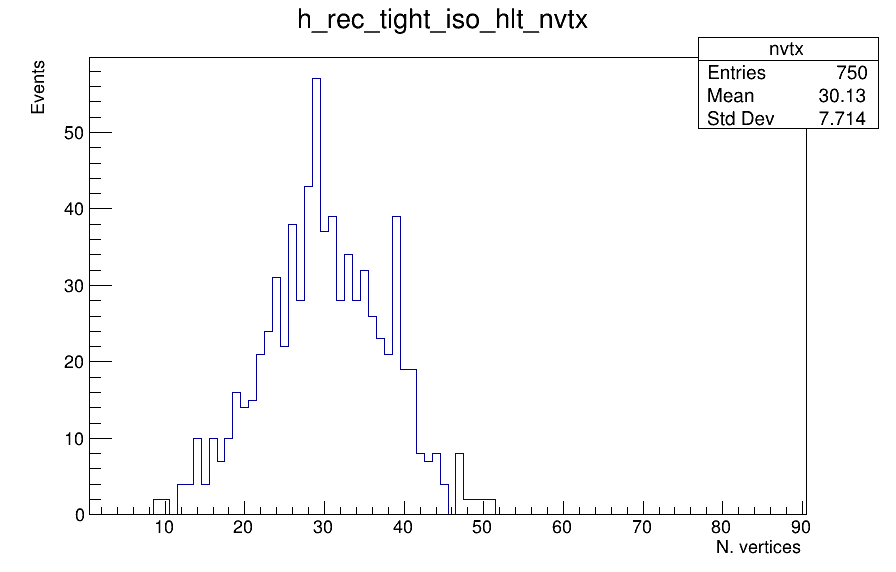

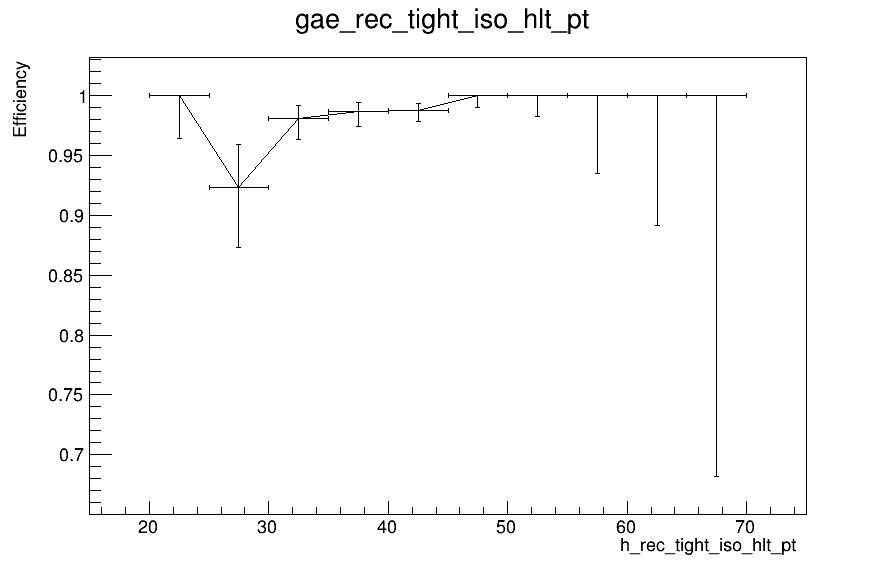

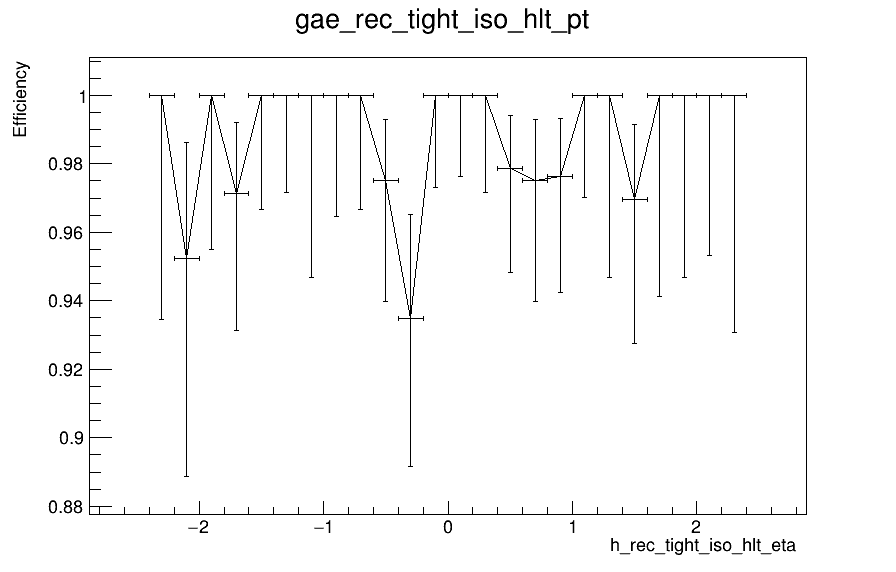

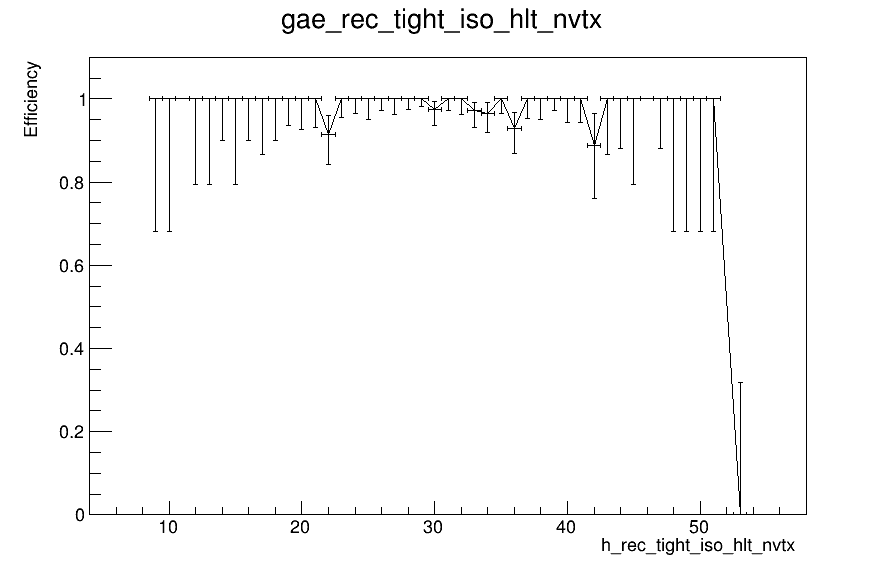

In [46]:
th1dic={}
efficiencydic={}
for name in ['rec', 'rec_loose', 'rec_medium', 'rec_tight', 'rec_tight_iso', 'rec_tight_iso_hlt']:
    if name== 'rec':
        th1dic[f'h_{name}_pt']=ROOT.TH1D("pt"  , f'h_{name}_pt;muon p_T [GeV];Events',  20,  20.0, 120.0)
        TH1_fill_and_plot(th1dic[f'h_{name}_pt'], muon.pt[muon_mask[f'{name}']][event_mask_goodpv], f'h_{name}_pt')
        th1dic[f'h_{name}_eta']=ROOT.TH1D("eta" , f'h_{name}_eta;muon #eta;Events',  24,  -2.4,   2.4)
        TH1_fill_and_plot(th1dic[f'h_{name}_eta'], muon.eta[muon_mask[f'{name}']][event_mask_goodpv], f'h_{name}_eta')
        th1dic[f'h_{name}_nvtx'] =ROOT.TH1D("nvtx", f'h_{name}_nvtx;N. vertices;Events',  90,   0.5,  90.5)
        TH1_fill_and_plot(th1dic[f'h_{name}_nvtx'], muon.PV_npvsGood[muon_mask[f'{name}']][event_mask_goodpv], f'h_{name}_nvtx')
        
        name2=name
        continue
        
    if name== 'rec_tight_iso_hlt':
        th1dic[f'h_{name}_pt']=ROOT.TH1D("pt"  , f'h_{name}_pt;muon p_T [GeV];Events',  20,  20.0, 120.0)
        TH1_fill_and_plot(th1dic[f'h_{name}_pt'], muon.pt[muon_mask[f'{name}']][event_mask_goodpv_HLT_isomu24], f'h_{name}_pt')
        th1dic[f'h_{name}_eta']=ROOT.TH1D("eta" , f'h_{name}_eta;muon #eta;Events',  24,  -2.4,   2.4)
        TH1_fill_and_plot(th1dic[f'h_{name}_eta'], muon.eta[muon_mask[f'{name}']][event_mask_goodpv_HLT_isomu24], f'h_{name}_eta')
        th1dic[f'h_{name}_nvtx'] =ROOT.TH1D("nvtx", f'h_{name}_nvtx;N. vertices;Events',  90,   0.5,  90.5)
        TH1_fill_and_plot(th1dic[f'h_{name}_nvtx'], muon.PV_npvsGood[muon_mask[f'{name}']][event_mask_goodpv_HLT_isomu24], f'h_{name}_nvtx')

        nbinpt   = th1dic['h_rec_pt'].GetNbinsX() 
        nbineta  = th1dic['h_rec_eta'].GetNbinsX() 
        nbinnvtx = th1dic['h_rec_nvtx'].GetNbinsX()
        
        efficiencydic[f'gae_{name}_pt']   = ROOT.TGraphAsymmErrors(nbinpt  ) 
        efficiencydic[f'gae_{name}_pt'].SetName(f'gae_{name}_pt')
        efficiencydic[f'gae_{name}_pt'].SetTitle(f'gae_{name}_pt')
        efficiencydic[f'gae_{name}_pt'].GetXaxis().SetTitle(f'h_{name}_pt')
        efficiencydic[f'gae_{name}_pt'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_pt'].Divide(th1dic[f'h_{name}_pt']  , th1dic[f'h_{name2}_pt']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_pt'], f'gae_{name}_pt')
        
        efficiencydic[f'gae_{name}_eta']   = ROOT.TGraphAsymmErrors(nbineta ) 
        efficiencydic[f'gae_{name}_eta'].SetName(f'gae_{name}_pt')
        efficiencydic[f'gae_{name}_eta'].SetTitle(f'gae_{name}_pt')
        efficiencydic[f'gae_{name}_eta'].GetXaxis().SetTitle(f'h_{name}_eta')
        efficiencydic[f'gae_{name}_eta'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_eta'].Divide(th1dic[f'h_{name}_eta']  , th1dic[f'h_{name2}_eta']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_eta'], f'gae_{name}_eta')
        
        efficiencydic[f'gae_{name}_nvtx']   = ROOT.TGraphAsymmErrors(nbinnvtx ) 
        efficiencydic[f'gae_{name}_nvtx'].SetName(f'gae_{name}_nvtx')
        efficiencydic[f'gae_{name}_nvtx'].SetTitle(f'gae_{name}_nvtx')
        efficiencydic[f'gae_{name}_nvtx'].GetXaxis().SetTitle(f'h_{name}_nvtx')
        efficiencydic[f'gae_{name}_nvtx'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_nvtx'].Divide(th1dic[f'h_{name}_nvtx']  , th1dic[f'h_{name2}_nvtx']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_nvtx'], f'gae_{name}_nvtx')
        
        name2=name
    else:
        th1dic[f'h_{name}_pt']=ROOT.TH1D("pt"  , f'h_{name}_pt;muon p_T [GeV];Events',  20,  20.0, 120.0)
        TH1_fill_and_plot(th1dic[f'h_{name}_pt'], muon.pt[muon_mask[f'{name}']][event_mask_goodpv], f'h_{name}_pt')
        th1dic[f'h_{name}_eta']=ROOT.TH1D("eta" , f'h_{name}_eta;muon #eta;Events',  24,  -2.4,   2.4)
        TH1_fill_and_plot(th1dic[f'h_{name}_eta'], muon.eta[muon_mask[f'{name}']][event_mask_goodpv], f'h_{name}_eta')
        th1dic[f'h_{name}_nvtx'] =ROOT.TH1D("nvtx", f'h_{name}_nvtx;N. vertices;Events',  90,   0.5,  90.5)
        TH1_fill_and_plot(th1dic[f'h_{name}_nvtx'], muon.PV_npvsGood[muon_mask[f'{name}']][event_mask_goodpv], f'h_{name}_nvtx')
        
        nbinpt   = th1dic['h_rec_pt'].GetNbinsX() 
        nbineta  = th1dic['h_rec_eta'].GetNbinsX() 
        nbinnvtx = th1dic['h_rec_nvtx'].GetNbinsX()
        
        efficiencydic[f'gae_{name}_pt']   = ROOT.TGraphAsymmErrors(nbinpt  ) 
        efficiencydic[f'gae_{name}_pt'].SetName(f'gae_{name}_pt')
        efficiencydic[f'gae_{name}_pt'].SetTitle(f'gae_{name}_pt')
        efficiencydic[f'gae_{name}_pt'].GetXaxis().SetTitle(f'h_{name}_pt')
        efficiencydic[f'gae_{name}_pt'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_pt'].Divide(th1dic[f'h_{name}_pt']  , th1dic[f'h_{name2}_pt']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_pt'], f'gae_{name}_pt')
        
        efficiencydic[f'gae_{name}_eta']   = ROOT.TGraphAsymmErrors(nbineta ) 
        efficiencydic[f'gae_{name}_eta'].SetName(f'gae_{name}_pt')
        efficiencydic[f'gae_{name}_eta'].SetTitle(f'gae_{name}_pt')
        efficiencydic[f'gae_{name}_eta'].GetXaxis().SetTitle(f'h_{name}_eta')
        efficiencydic[f'gae_{name}_eta'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_eta'].Divide(th1dic[f'h_{name}_eta']  , th1dic[f'h_{name2}_eta']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_eta'], f'gae_{name}_eta')
        
        efficiencydic[f'gae_{name}_nvtx']   = ROOT.TGraphAsymmErrors(nbinnvtx ) 
        efficiencydic[f'gae_{name}_nvtx'].SetName(f'gae_{name}_nvtx')
        efficiencydic[f'gae_{name}_nvtx'].SetTitle(f'gae_{name}_nvtx')
        efficiencydic[f'gae_{name}_nvtx'].GetXaxis().SetTitle(f'h_{name}_nvtx')
        efficiencydic[f'gae_{name}_nvtx'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_nvtx'].Divide(th1dic[f'h_{name}_nvtx']  , th1dic[f'h_{name2}_nvtx']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_nvtx'], f'gae_{name}_nvtx')
        
        name2=name


Questions 1:
* In the tag selection, you requested that the tag muon be matched to a trigger object. Why is it important to make sure that the tag has fired a trigger?
* In the MC-truth approach, you can use both muons in the event to measure the efficiency. In the tag-and-probe, you only use the probe. Does this mean that you can use only one muon per event?
* Do you observe significant differences between the "true" efficiencies and the tag-and-probe ones? In what plots and in what regions? What is the maximum size of the differences?
What factors might impact or bias the tag-and-probe efficiency estimate?

**Answers 1:**
* Requiring the tag to have fired the trigger makes sure that the event was recorded independently of the probe muon. This removes potentially biases fromt he efficiency measurements, especially for trigger efficiency. 
* No, every muon pass some basic criteria could be a probe. if there are multiple muons meet probe criteria, it is matched to a tag muon to determine which one could be a muon from z.
* The "true" reconstruction efficiency, at least as a function of eta and phi, is much lower than what is seen with tag and probe. This is because we include a lot of very low pT muons in the denominator that we do not incude in the numerator. In the Tag & Probe measurement, we require the presence of a muon already in the denominator, leading to much higher reconstruction efficiencies. For the other efficiencies, similar results are observed between the direct measurement and Tag & Probe. 

# Step 3: Run the "Tag-and-Probe" analyzer on real data

As already mentioned, the tag-and-probe approach is data driven. The analyzer does not access any generator-level information, thus you can safely run it on real data. The following sample--Run2016G_SingleMuon_NANOAOD.root is taken from the 2016G CMS data set, SingleMuon stream, requiring at least a good tag candidate and a good probe candidate per event.

In [23]:

events = NanoEventsFactory.from_root(
    {"~/work/projects/hats2024/data/MuonData.root": "Events"}, # We pass a dictionary of {filename1: treename1, filename2: treename2, ...} to load from
    schemaclass=NanoAODSchema,
    metadata={"dataset": "Data"},
    delayed=False, # You can turn this to True and insert `` commands at the end of variables
    entry_stop = 100000,
).events()

In [24]:
events["Muon","PV_npvsGood"] = events.PV.npvsGood
muon = events.Muon

In [25]:
trigger_muon= events.TrigObj[abs(events.TrigObj.id)==13]

In [26]:
def deltaR(probe, trigger):
    return np.sqrt((probe.eta-trigger.eta)**2+((probe.phi-trigger.phi+pi)%(2*pi)-pi)**2)

def trigger_match(leptons, trigobjs, pdgid, pt, filterbit):
        pass_pt = trigobjs.pt > pt
        pass_id = abs(trigobjs.id) == pdgid
        pass_filterbit = (trigobjs.filterBits & (0x1 << filterbit)) != 0
        trigger_cands = trigobjs[pass_pt & pass_id & pass_filterbit]
        delta_r = leptons.metric_table(trigger_cands, metric=deltaR)
        pass_delta_r = delta_r < 0.1
        n_of_trigger_matches = ak.sum(pass_delta_r, axis=2)
        trig_matched_locs = n_of_trigger_matches >= 1

        return trig_matched_locs

In [27]:
trigger_match_mask = trigger_match(muon, trigger_muon, 13, 0, 8 )

In [28]:
tag_muon_mask=(muon.pt>25)& (abs(muon.eta)<2.4)& (muon.tightId==1)& (muon.dz<0.1)& (muon.pfRelIso04_all< 0.12)& trigger_match_mask

In [29]:
tag_muon= muon [tag_muon_mask]

In [30]:
probe_muon_mask=[]
# make sure the z mass is within 91+-5 window
for tag4s, probe4s, in zip(tag_muon, muon):
    list=[]
    if len(probe4s)==0:
        probe_muon_mask.append([])
        continue
    for probe4 in probe4s:
        bestmass=0
        if len(tag4s)==0:
            list.append(False)
            continue
        for tag4 in tag4s:
            if tag4.charge*probe4.charge>0:
                continue
            mass=sqrt(2*tag4.pt*probe4.pt*(cosh(tag4.eta - probe4.eta) - cos(tag4.phi - probe4.phi)))
            if abs(mass-91.)>5.:
                continue
            else:
                bestmass= mass
                break
        if bestmass!=0:
            list.append(True)
        else:
            list.append(False)
    probe_muon_mask.append(list)

In [31]:
event_mask_goodpv= events.PV.npvsGood>0 #at least a good vertex

In [32]:
event_mask_goodpv_HLT_isomu24= (events.PV.npvsGood>0)& (events.HLT.IsoMu24==1)#fired the iso muon trigger

In [33]:
probe_muon_masking= (ak.from_iter(probe_muon_mask)& (muon.pt>20)& (abs(muon.eta)<2.4))

In [34]:
probe_muon= muon[probe_muon_masking]

In [35]:
muon_mask={}
muon_mask['rec']= probe_muon_masking
muon_mask['rec_loose']= probe_muon_masking& (muon.looseId==1) 
muon_mask['rec_medium']= probe_muon_masking& (muon.mediumId==1) 
muon_mask['rec_tight']=  probe_muon_masking& (muon.tightId==1)& (muon.mediumId==1)
muon_mask['rec_tight_iso']= probe_muon_masking& (muon.tightId==1)& (muon.pfRelIso04_all< 0.12)& (muon.mediumId==1)
muon_mask['rec_tight_iso_hlt']= probe_muon_masking& (muon.tightId==1)& (muon.pfRelIso04_all< 0.12)& (muon.mediumId==1) & trigger_match_mask

Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_rec_pt
Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_rec_eta
Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_rec_nvtx
Warning in <TROOT::Append>: Replacing existing TH1: pt (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_rec_loose_pt
Warning in <TROOT::Append>: Replacing existing TH1: eta (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_rec_loose_eta
Warning in <TROOT::Append>: Replacing existing TH1: nvtx (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_rec_loose_nvtx
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 2 points have been skipped
Warning in <TCanvas::Constructor>: Deleting canvas with same name: gae_rec_loose_pt
Warning in <TCanvas::Constructor>: Deleting canvas with same name: g

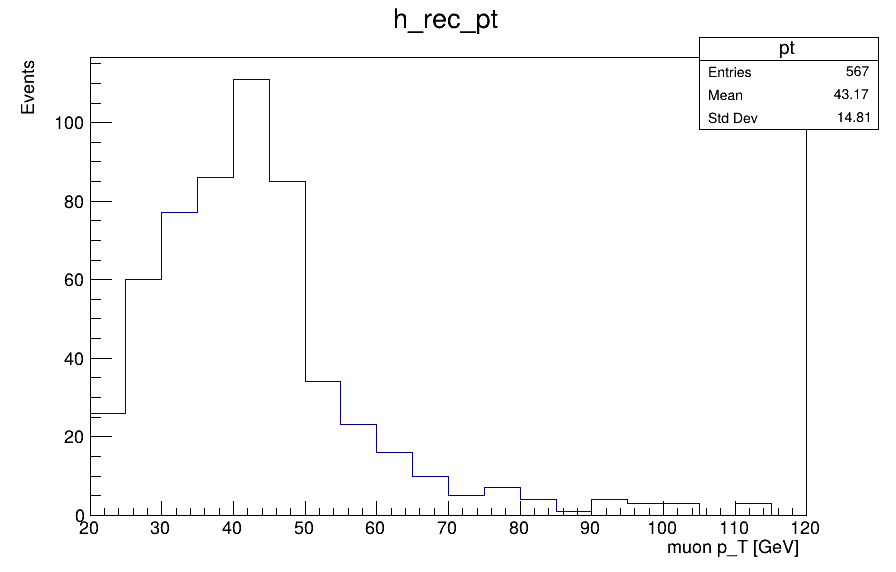

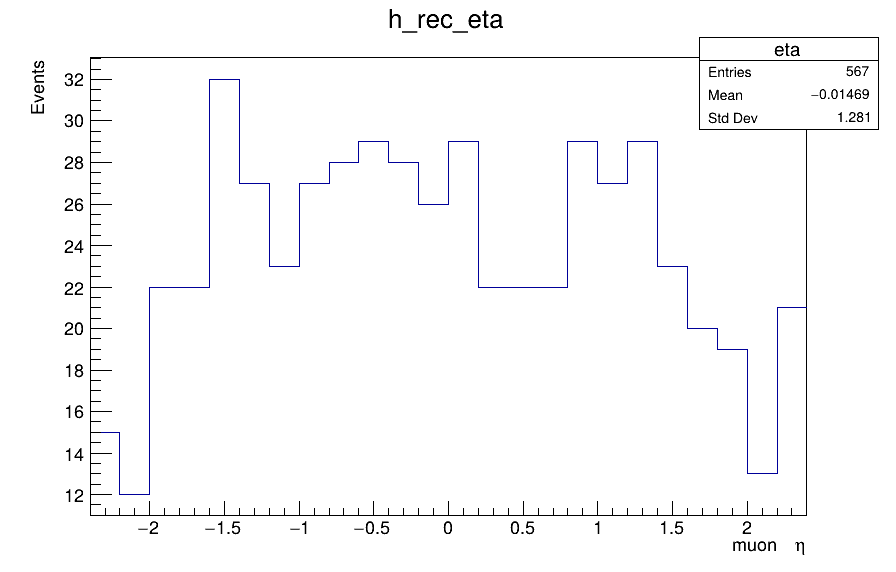

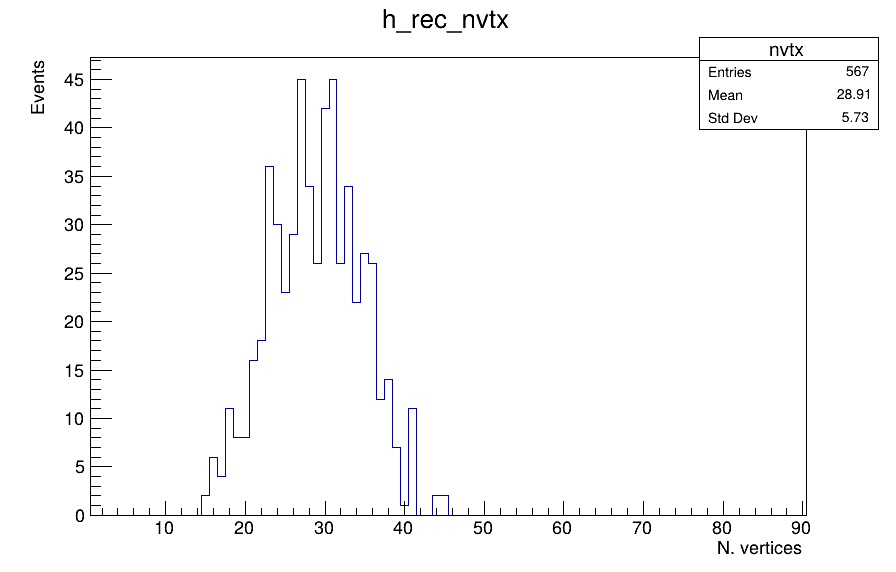

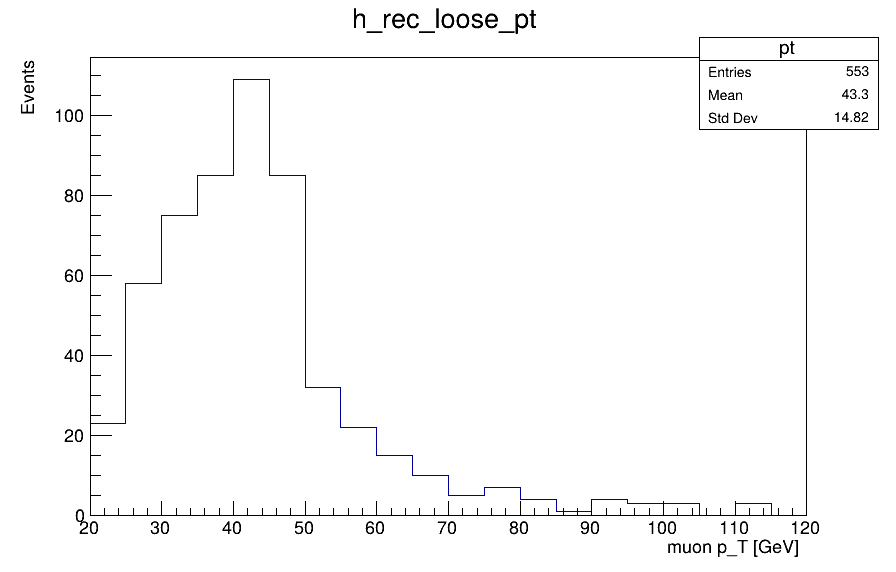

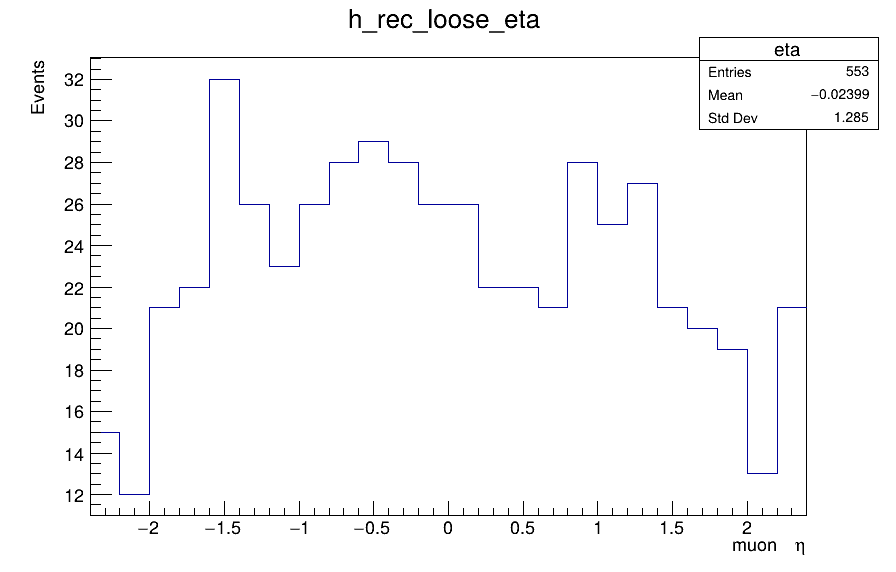

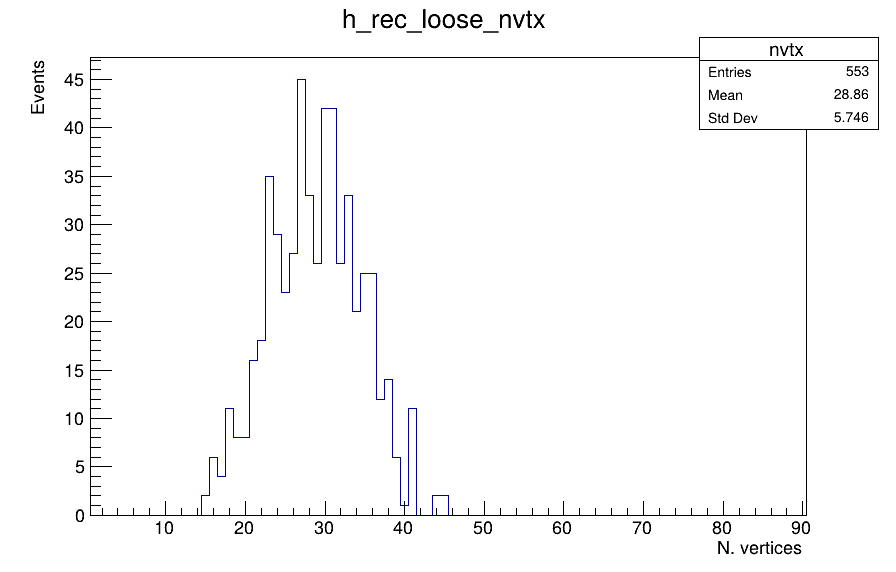

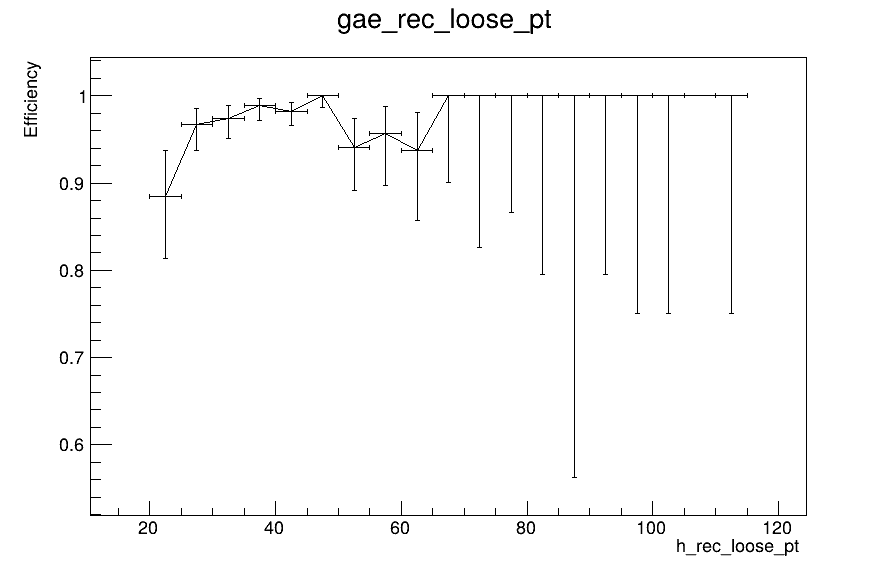

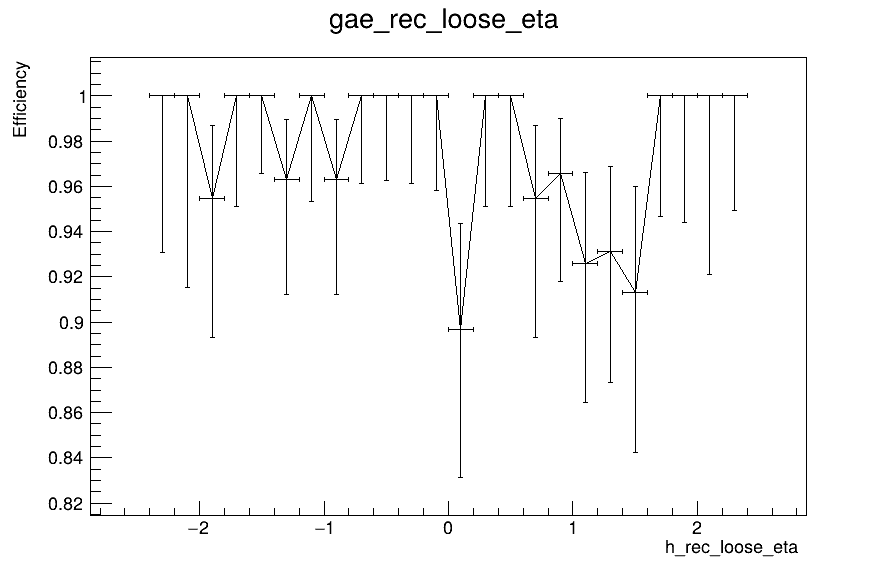

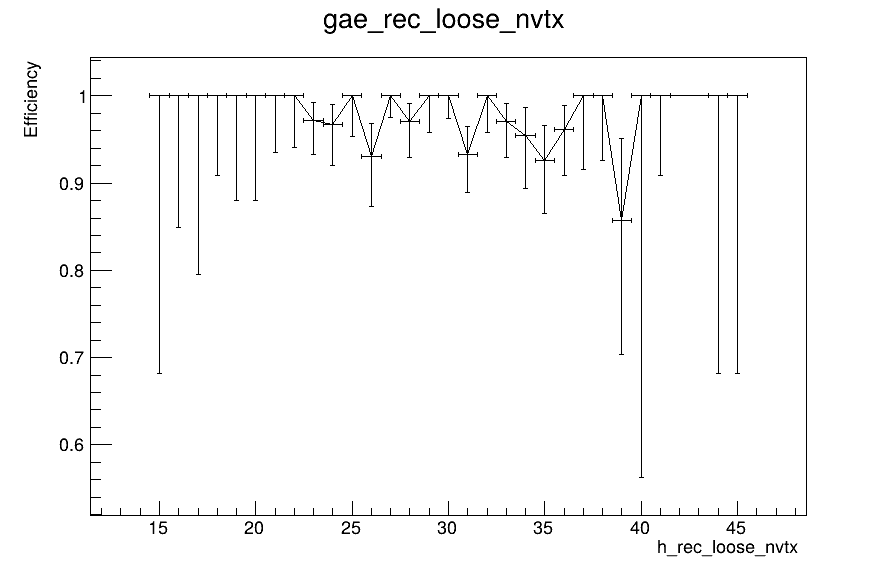

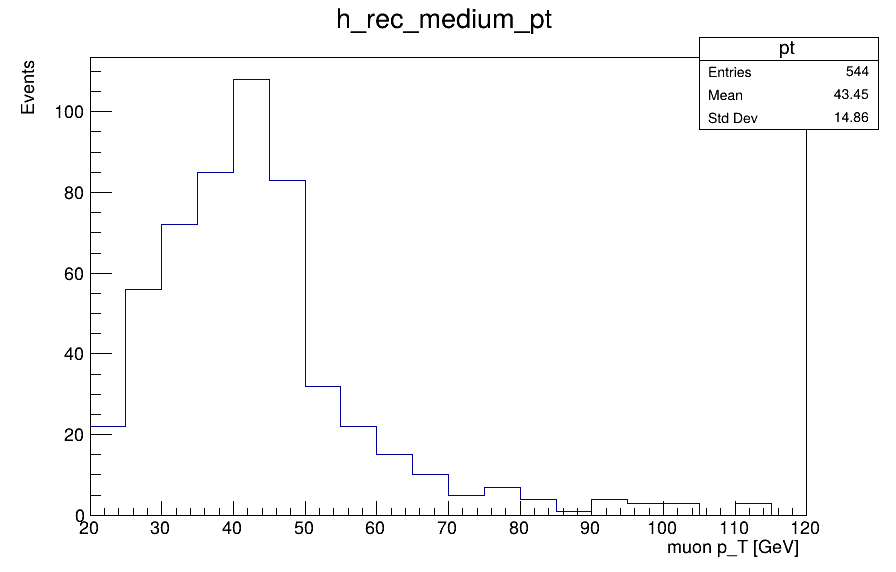

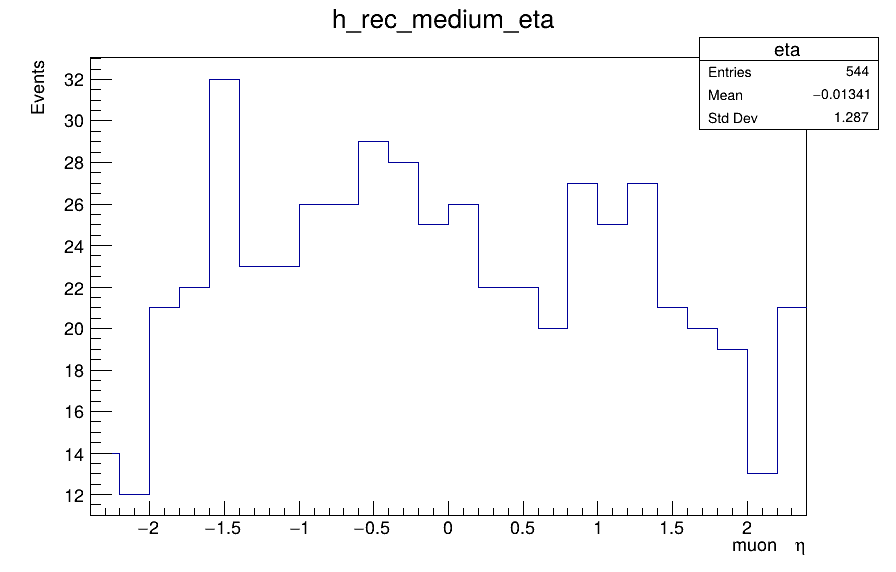

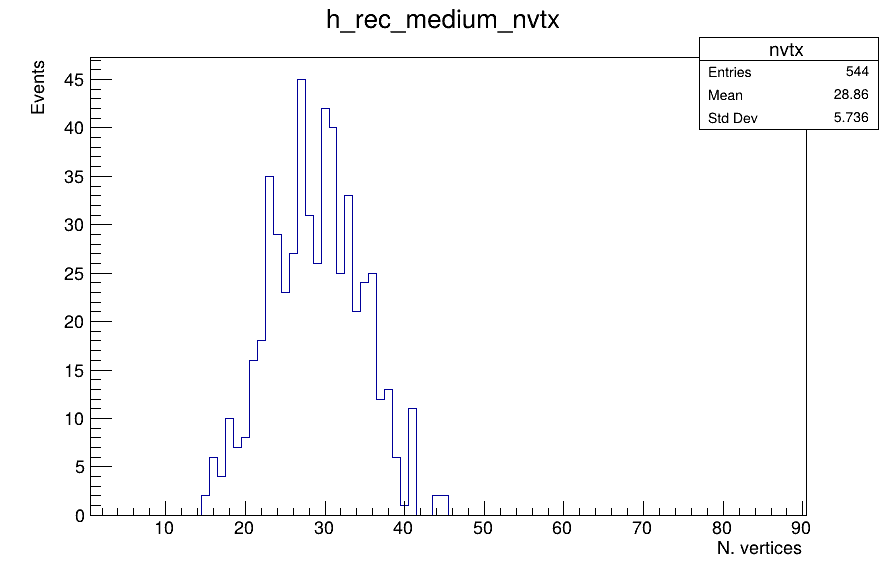

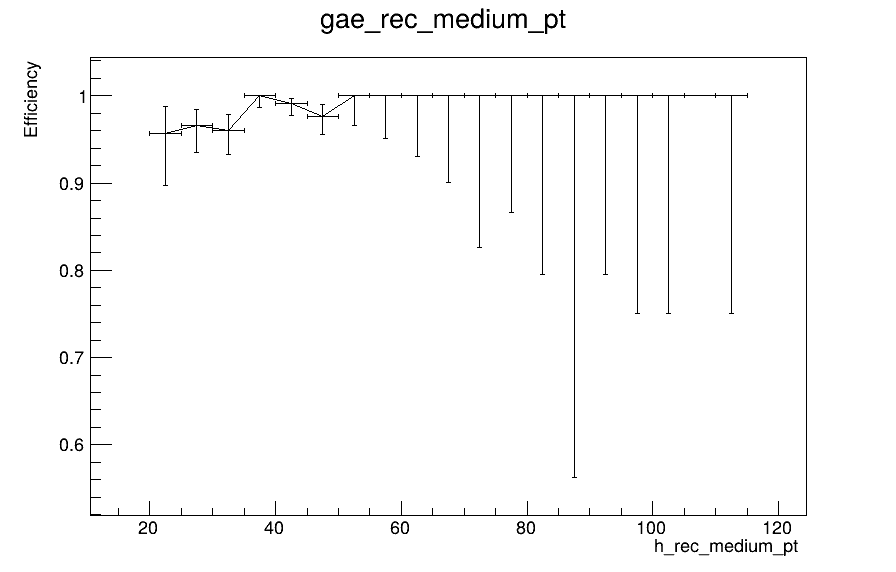

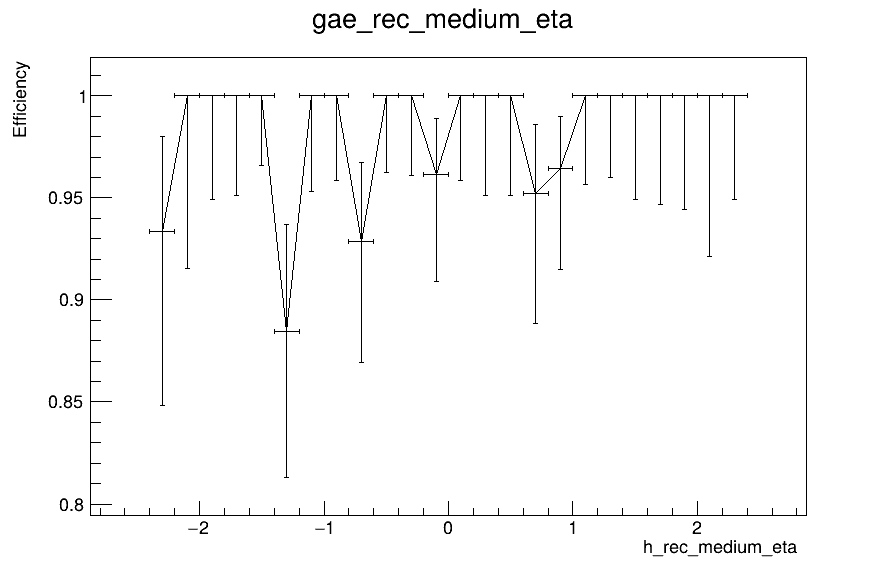

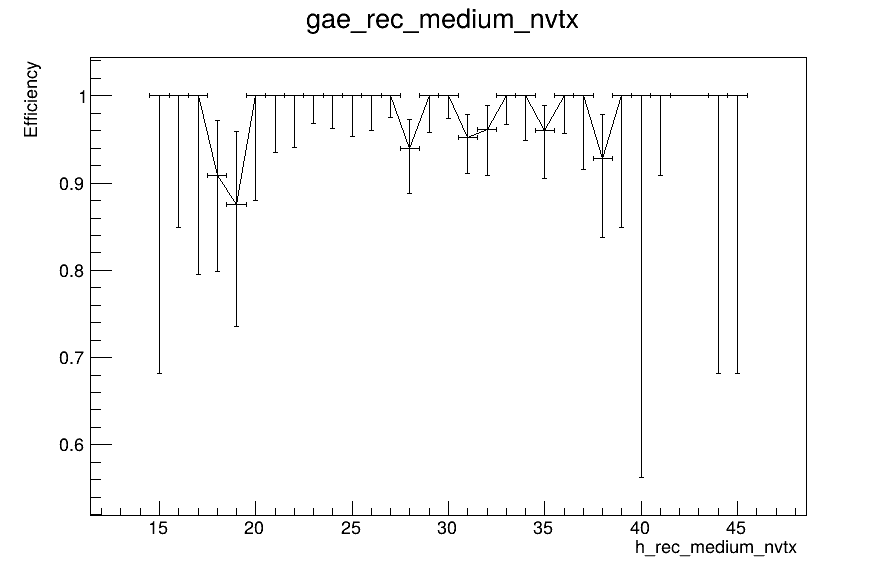

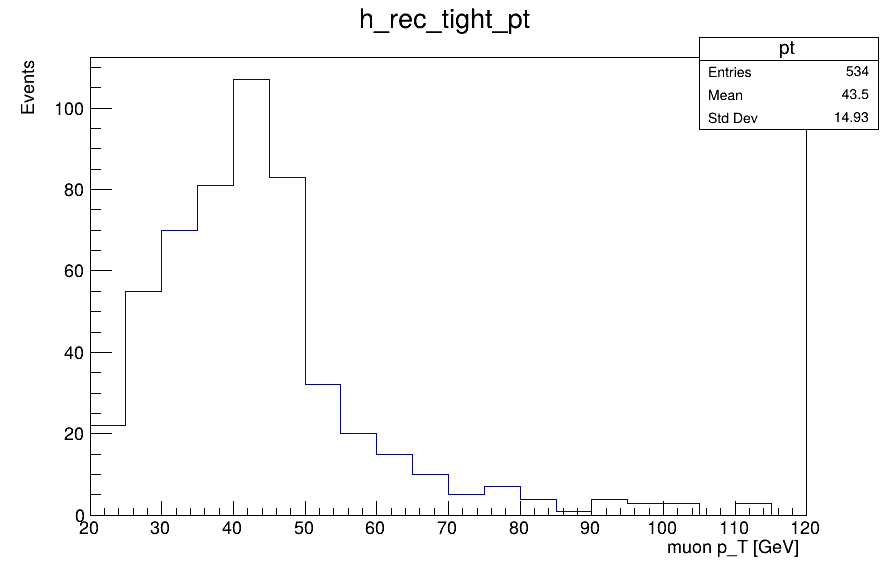

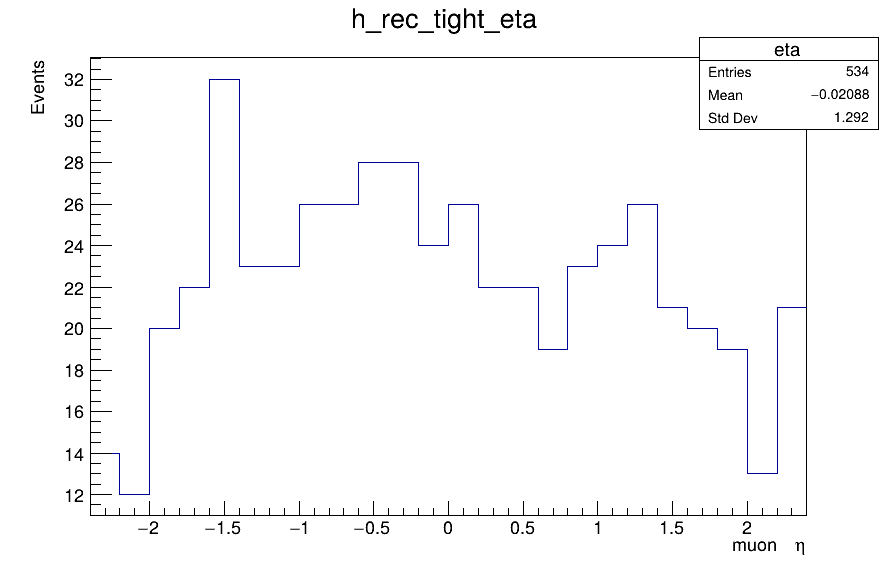

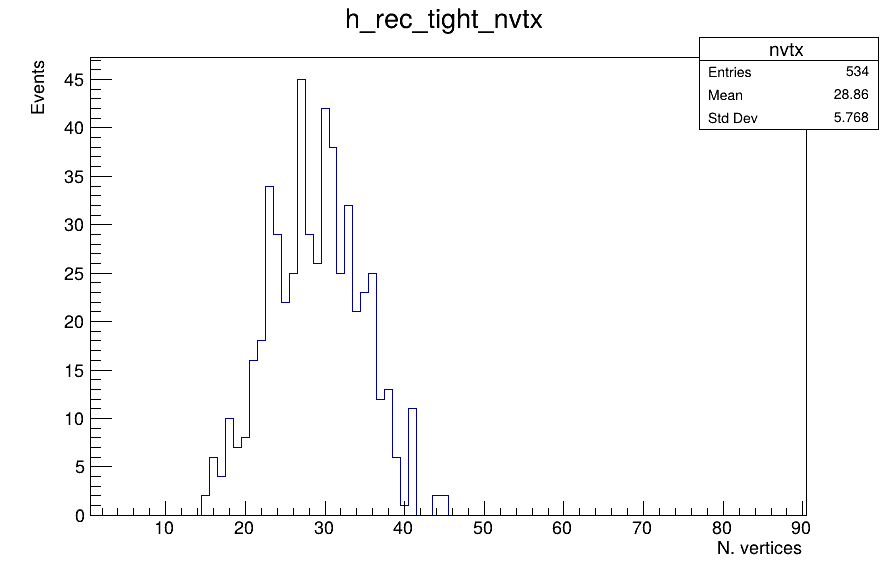

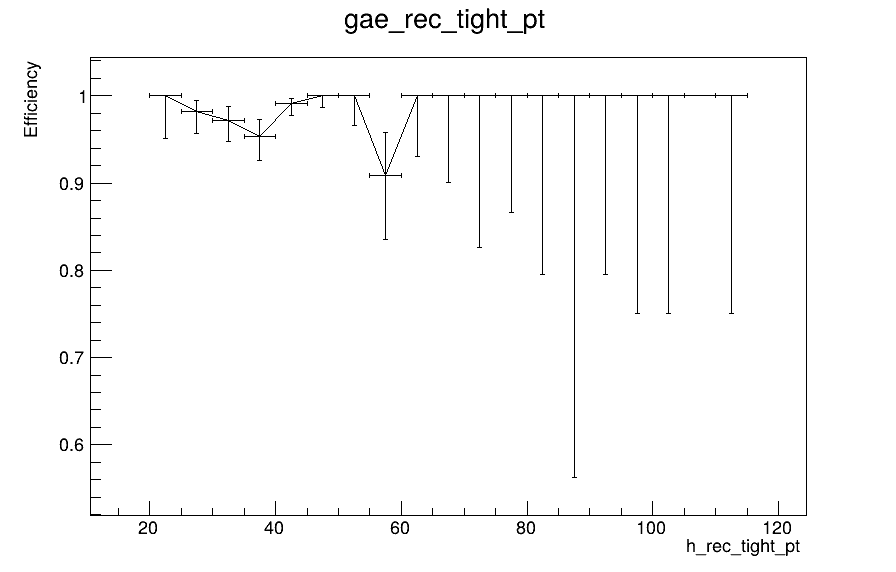

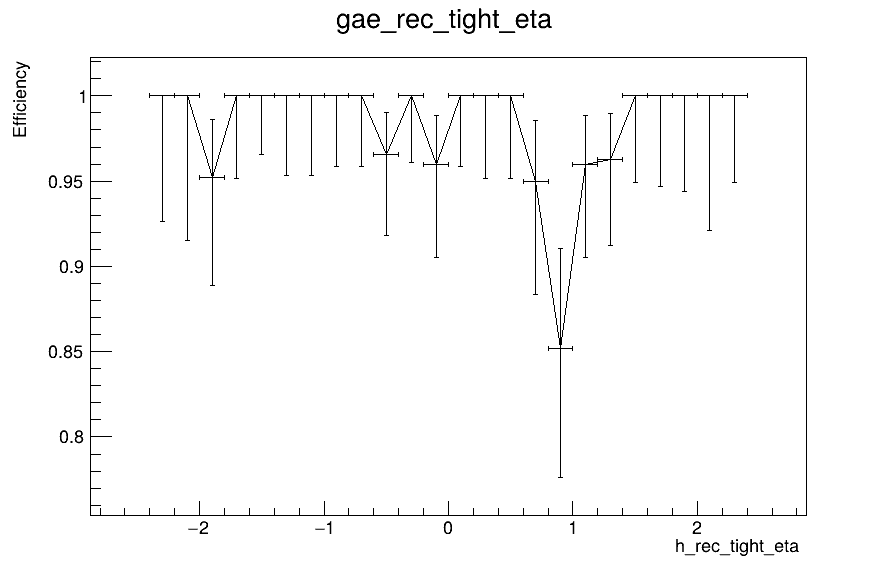

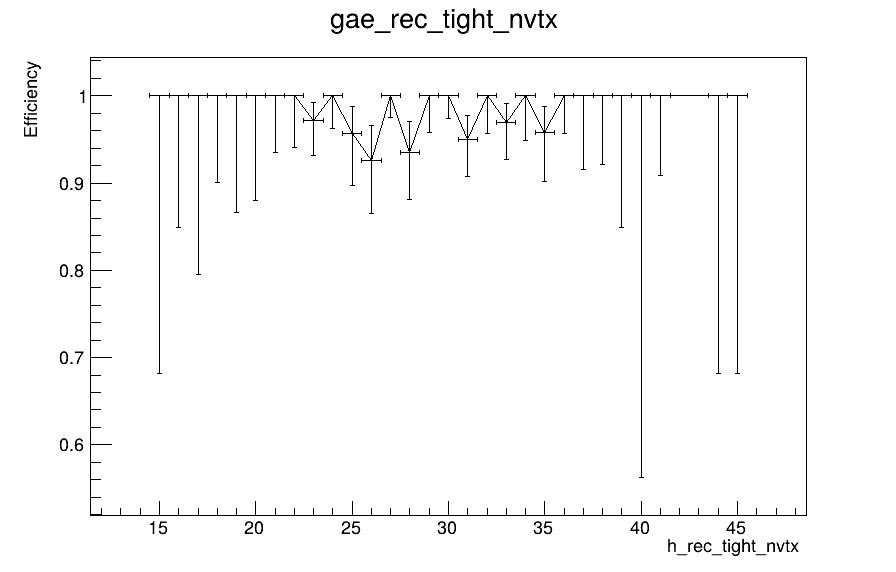

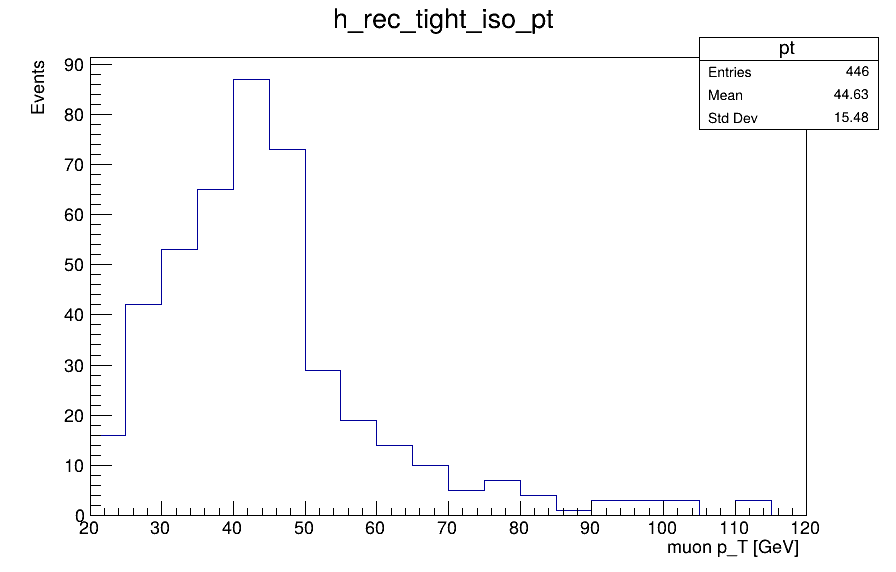

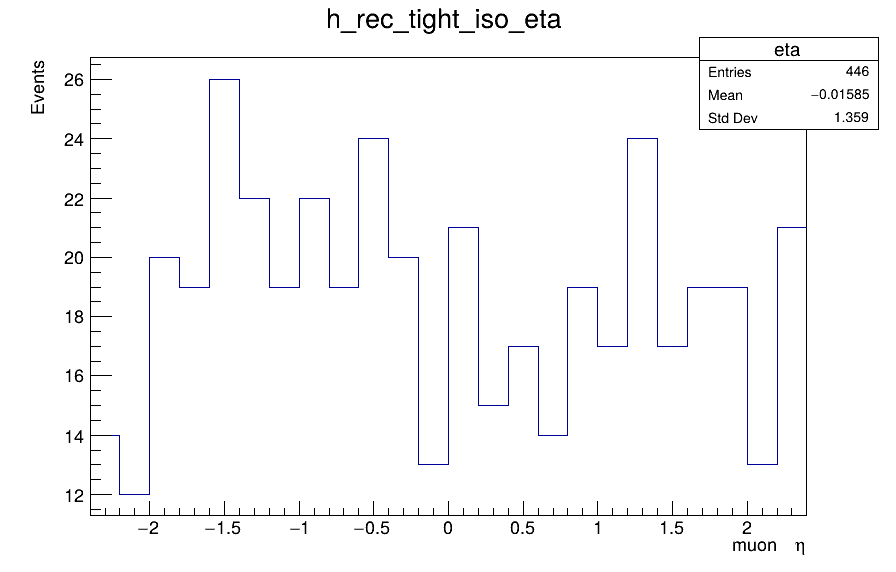

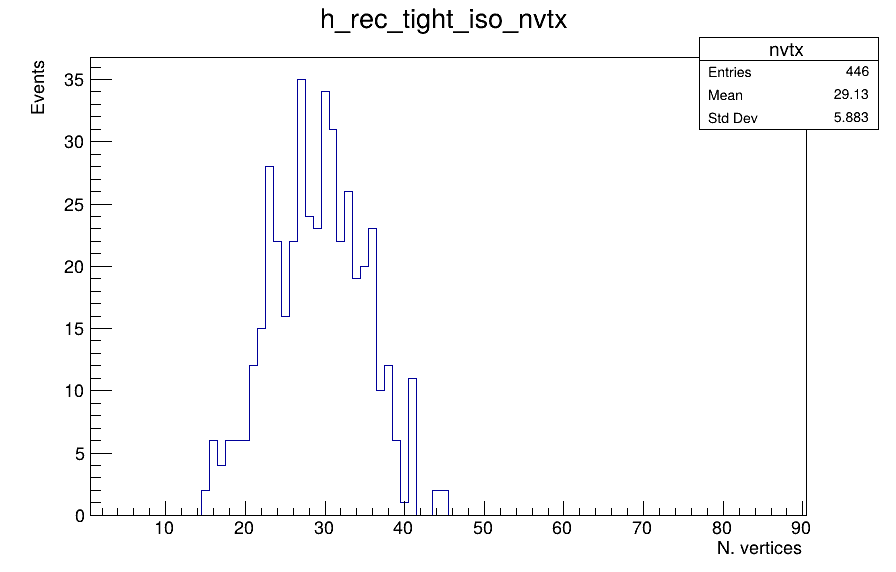

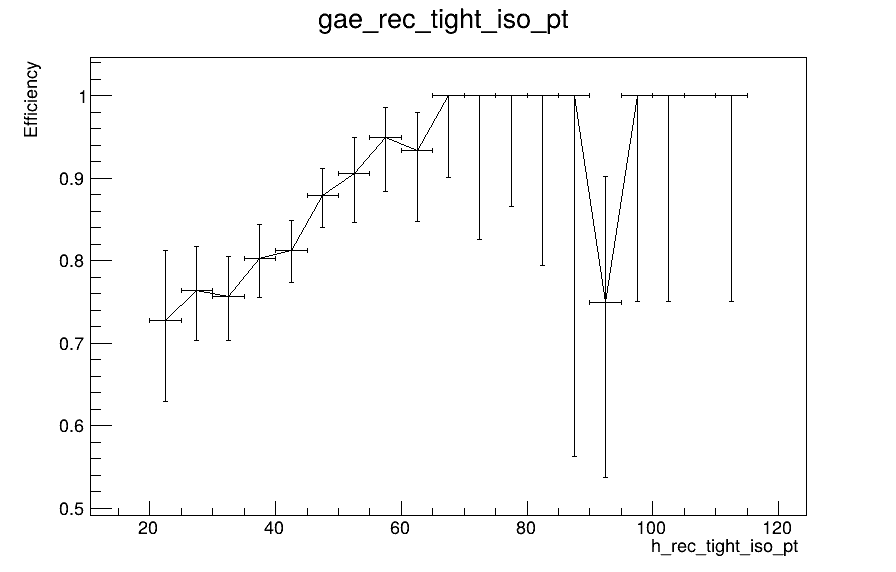

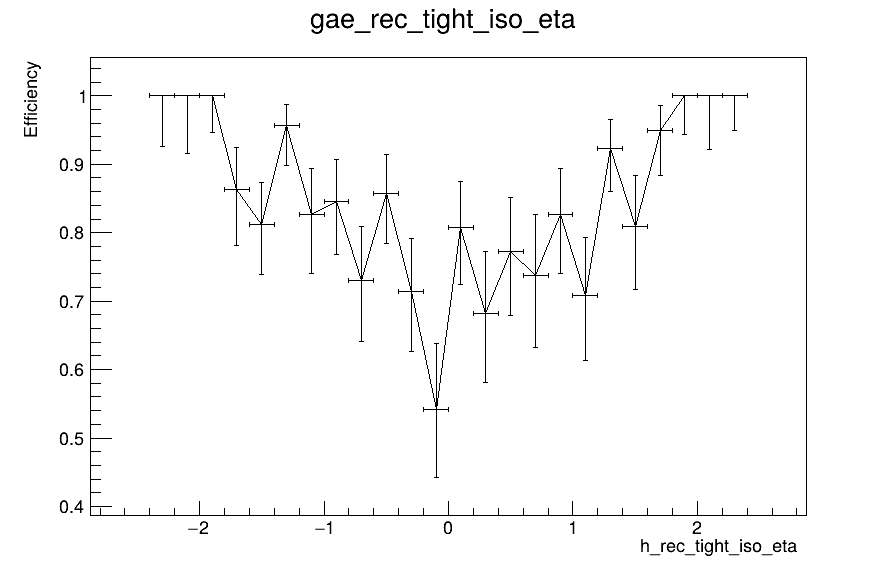

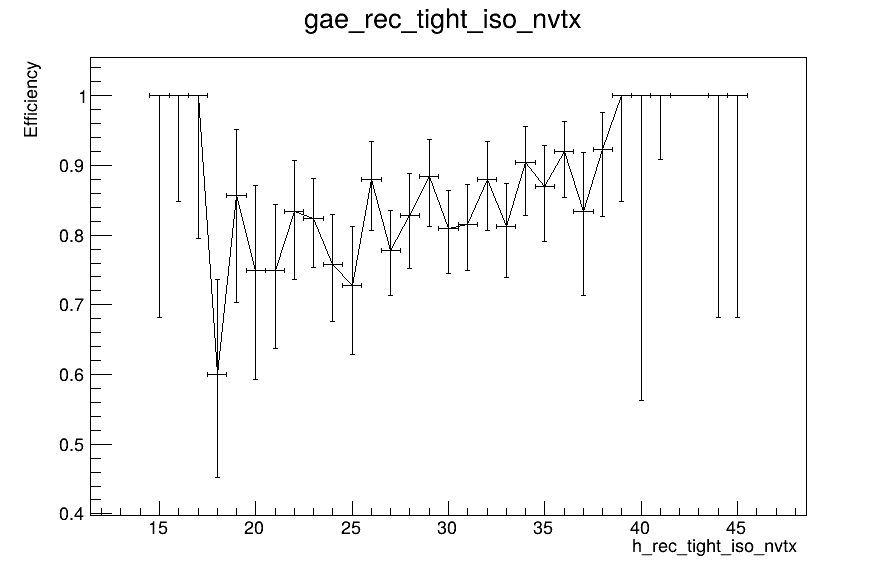

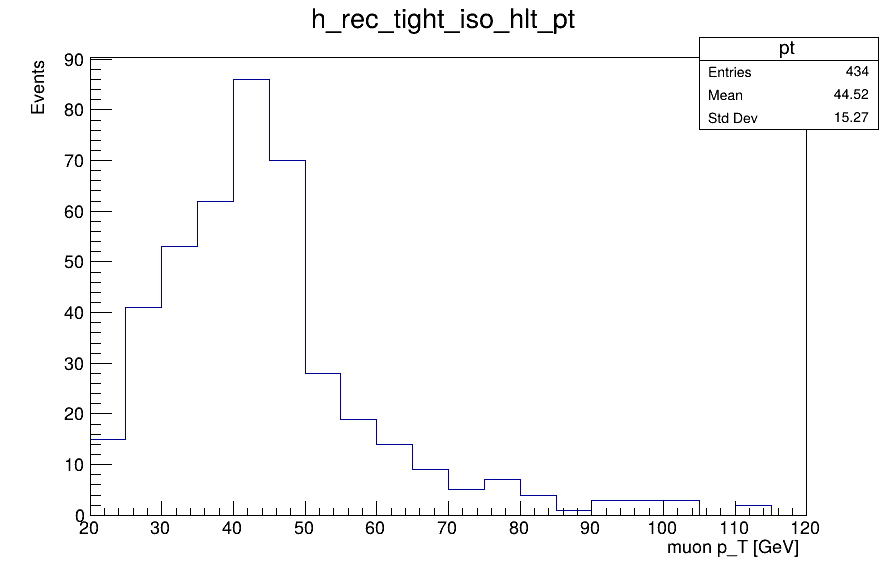

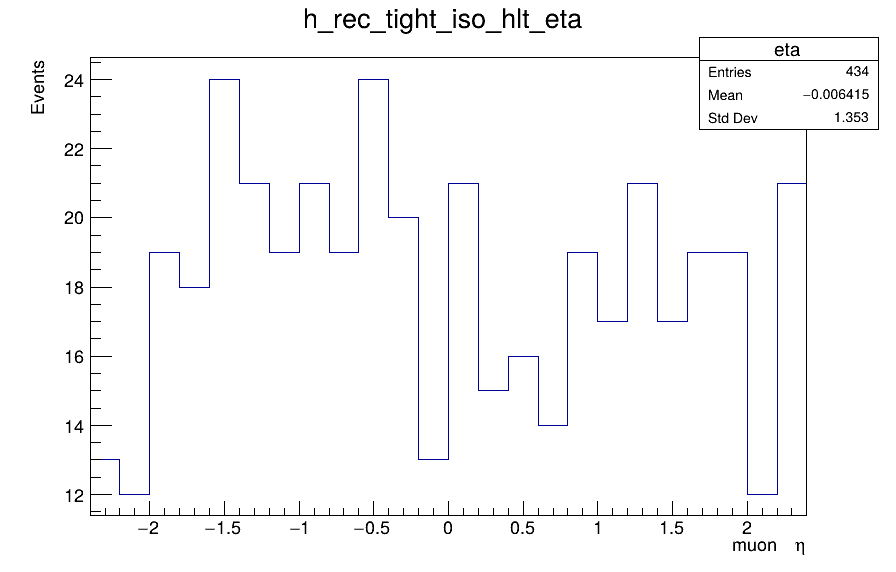

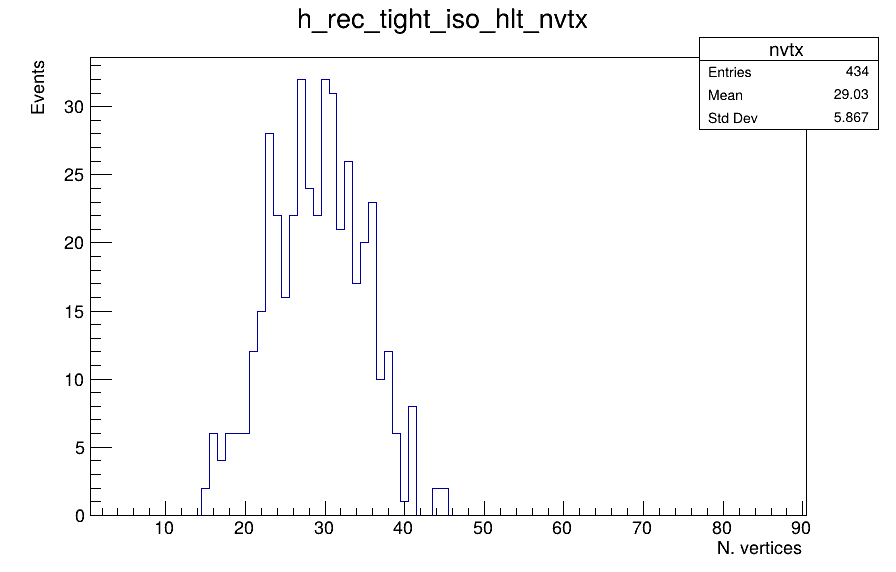

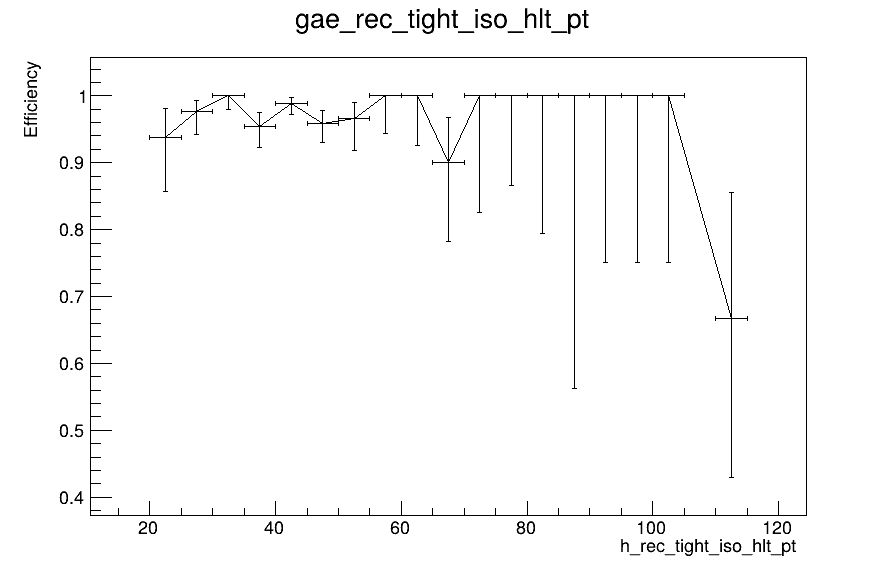

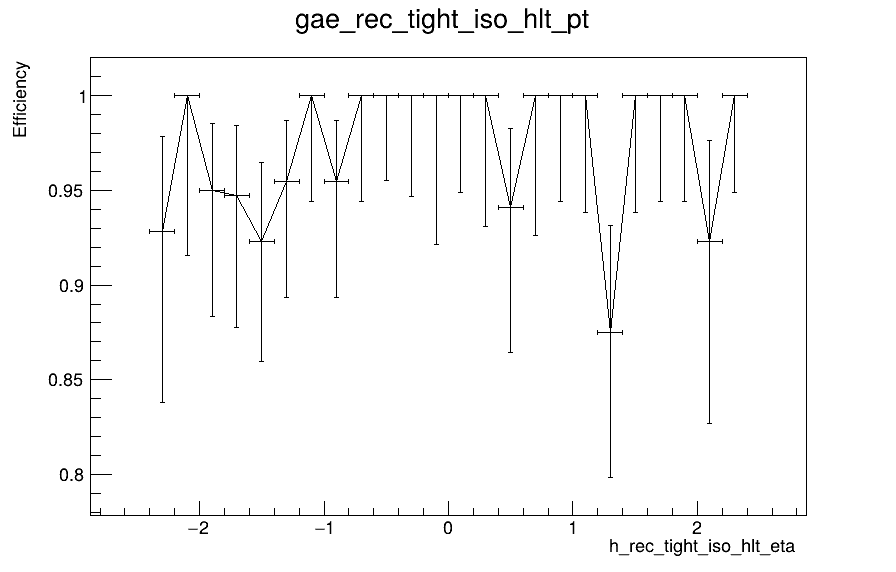

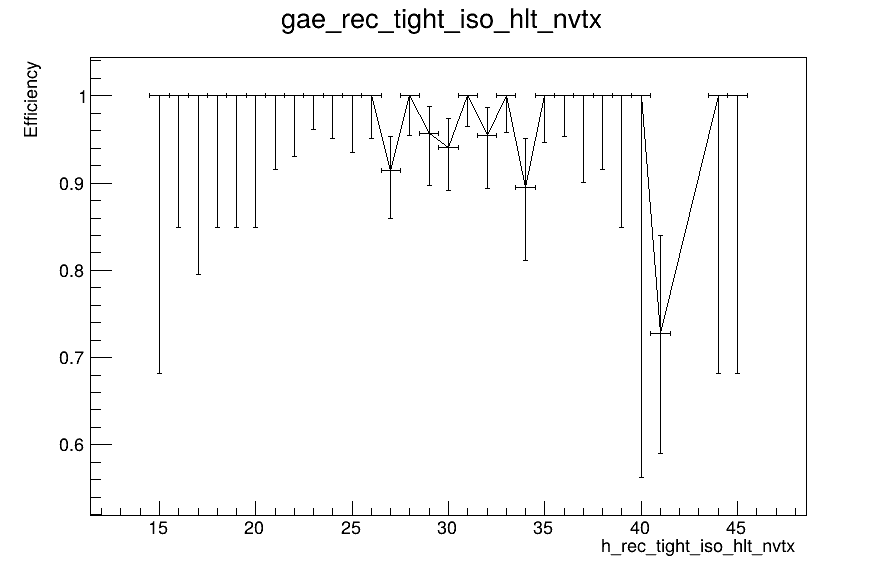

In [36]:
th1dic={}
efficiencydic={}
for name in ['rec', 'rec_loose', 'rec_medium', 'rec_tight', 'rec_tight_iso', 'rec_tight_iso_hlt']:
    if name== 'rec':
        th1dic[f'h_{name}_pt']=ROOT.TH1D("pt"  , f'h_{name}_pt;muon p_T [GeV];Events',  20,  20.0, 120.0)
        TH1_fill_and_plot(th1dic[f'h_{name}_pt'], muon.pt[muon_mask[f'{name}']][event_mask_goodpv], f'h_{name}_pt')
        th1dic[f'h_{name}_eta']=ROOT.TH1D("eta" , f'h_{name}_eta;muon #eta;Events',  24,  -2.4,   2.4)
        TH1_fill_and_plot(th1dic[f'h_{name}_eta'], muon.eta[muon_mask[f'{name}']][event_mask_goodpv], f'h_{name}_eta')
        th1dic[f'h_{name}_nvtx'] =ROOT.TH1D("nvtx", f'h_{name}_nvtx;N. vertices;Events',  90,   0.5,  90.5)
        TH1_fill_and_plot(th1dic[f'h_{name}_nvtx'], muon.PV_npvsGood[muon_mask[f'{name}']][event_mask_goodpv], f'h_{name}_nvtx')
        
        name2=name
        continue
        
    if name== 'rec_tight_iso_hlt':
        th1dic[f'h_{name}_pt']=ROOT.TH1D("pt"  , f'h_{name}_pt;muon p_T [GeV];Events',  20,  20.0, 120.0)
        TH1_fill_and_plot(th1dic[f'h_{name}_pt'], muon.pt[muon_mask[f'{name}']][event_mask_goodpv_HLT_isomu24], f'h_{name}_pt')
        th1dic[f'h_{name}_eta']=ROOT.TH1D("eta" , f'h_{name}_eta;muon #eta;Events',  24,  -2.4,   2.4)
        TH1_fill_and_plot(th1dic[f'h_{name}_eta'], muon.eta[muon_mask[f'{name}']][event_mask_goodpv_HLT_isomu24], f'h_{name}_eta')
        th1dic[f'h_{name}_nvtx'] =ROOT.TH1D("nvtx", f'h_{name}_nvtx;N. vertices;Events',  90,   0.5,  90.5)
        TH1_fill_and_plot(th1dic[f'h_{name}_nvtx'], muon.PV_npvsGood[muon_mask[f'{name}']][event_mask_goodpv_HLT_isomu24], f'h_{name}_nvtx')

        nbinpt   = th1dic['h_rec_pt'].GetNbinsX() 
        nbineta  = th1dic['h_rec_eta'].GetNbinsX() 
        nbinnvtx = th1dic['h_rec_nvtx'].GetNbinsX()
        
        efficiencydic[f'gae_{name}_pt']   = ROOT.TGraphAsymmErrors(nbinpt  ) 
        efficiencydic[f'gae_{name}_pt'].SetName(f'gae_{name}_pt')
        efficiencydic[f'gae_{name}_pt'].SetTitle(f'gae_{name}_pt')
        efficiencydic[f'gae_{name}_pt'].GetXaxis().SetTitle(f'h_{name}_pt')
        efficiencydic[f'gae_{name}_pt'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_pt'].Divide(th1dic[f'h_{name}_pt']  , th1dic[f'h_{name2}_pt']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_pt'], f'gae_{name}_pt')
        
        efficiencydic[f'gae_{name}_eta']   = ROOT.TGraphAsymmErrors(nbineta ) 
        efficiencydic[f'gae_{name}_eta'].SetName(f'gae_{name}_eta')
        efficiencydic[f'gae_{name}_eta'].SetTitle(f'gae_{name}_pt')
        efficiencydic[f'gae_{name}_eta'].GetXaxis().SetTitle(f'h_{name}_eta')
        efficiencydic[f'gae_{name}_eta'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_eta'].Divide(th1dic[f'h_{name}_eta']  , th1dic[f'h_{name2}_eta']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_eta'], f'gae_{name}_eta')
        
        efficiencydic[f'gae_{name}_nvtx']   = ROOT.TGraphAsymmErrors(nbinnvtx ) 
        efficiencydic[f'gae_{name}_nvtx'].SetName(f'gae_{name}_nvtx')
        efficiencydic[f'gae_{name}_nvtx'].SetTitle(f'gae_{name}_nvtx')
        efficiencydic[f'gae_{name}_nvtx'].GetXaxis().SetTitle(f'h_{name}_nvtx')
        efficiencydic[f'gae_{name}_nvtx'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_nvtx'].Divide(th1dic[f'h_{name}_nvtx']  , th1dic[f'h_{name2}_nvtx']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_nvtx'], f'gae_{name}_nvtx')
        
        name2=name
    else:
        th1dic[f'h_{name}_pt']=ROOT.TH1D("pt"  , f'h_{name}_pt;muon p_T [GeV];Events',  20,  20.0, 120.0)
        TH1_fill_and_plot(th1dic[f'h_{name}_pt'], muon.pt[muon_mask[f'{name}']][event_mask_goodpv], f'h_{name}_pt')
        th1dic[f'h_{name}_eta']=ROOT.TH1D("eta" , f'h_{name}_eta;muon #eta;Events',  24,  -2.4,   2.4)
        TH1_fill_and_plot(th1dic[f'h_{name}_eta'], muon.eta[muon_mask[f'{name}']][event_mask_goodpv], f'h_{name}_eta')
        th1dic[f'h_{name}_nvtx'] =ROOT.TH1D("nvtx", f'h_{name}_nvtx;N. vertices;Events',  90,   0.5,  90.5)
        TH1_fill_and_plot(th1dic[f'h_{name}_nvtx'], muon.PV_npvsGood[muon_mask[f'{name}']][event_mask_goodpv], f'h_{name}_nvtx')
        
        nbinpt   = th1dic['h_rec_pt'].GetNbinsX() 
        nbineta  = th1dic['h_rec_eta'].GetNbinsX() 
        nbinnvtx = th1dic['h_rec_nvtx'].GetNbinsX()
        
        efficiencydic[f'gae_{name}_pt']   = ROOT.TGraphAsymmErrors(nbinpt  ) 
        efficiencydic[f'gae_{name}_pt'].SetName(f'gae_{name}_pt')
        efficiencydic[f'gae_{name}_pt'].SetTitle(f'gae_{name}_pt')
        efficiencydic[f'gae_{name}_pt'].GetXaxis().SetTitle(f'h_{name}_pt')
        efficiencydic[f'gae_{name}_pt'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_pt'].Divide(th1dic[f'h_{name}_pt']  , th1dic[f'h_{name2}_pt']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_pt'], f'gae_{name}_pt')
        
        efficiencydic[f'gae_{name}_eta']   = ROOT.TGraphAsymmErrors(nbineta ) 
        efficiencydic[f'gae_{name}_eta'].SetName(f'gae_{name}_eta')
        efficiencydic[f'gae_{name}_eta'].SetTitle(f'gae_{name}_eta')
        efficiencydic[f'gae_{name}_eta'].GetXaxis().SetTitle(f'h_{name}_eta')
        efficiencydic[f'gae_{name}_eta'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_eta'].Divide(th1dic[f'h_{name}_eta']  , th1dic[f'h_{name2}_eta']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_eta'], f'gae_{name}_eta')
        
        efficiencydic[f'gae_{name}_nvtx']   = ROOT.TGraphAsymmErrors(nbinnvtx ) 
        efficiencydic[f'gae_{name}_nvtx'].SetName(f'gae_{name}_nvtx')
        efficiencydic[f'gae_{name}_nvtx'].SetTitle(f'gae_{name}_nvtx')
        efficiencydic[f'gae_{name}_nvtx'].GetXaxis().SetTitle(f'h_{name}_nvtx')
        efficiencydic[f'gae_{name}_nvtx'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_nvtx'].Divide(th1dic[f'h_{name}_nvtx']  , th1dic[f'h_{name2}_nvtx']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_nvtx'], f'gae_{name}_nvtx')
        
        name2=name



Questions 2:
* Are there very significant differences between the data and MC efficiencies? In what plots and regions?
* What factors may cause differences between data and MC efficiencies? Is it possible to eliminate these differences?

In [ ]:
Answers 2:
* 

Are there very significant differences between the data and MC efficiencies? In what plots and regions?
* Based on the invariant mass distributions for different probe selections, which efficiencies are reliable in your opinion? Which are affected by too much background?
* Factors like the number of pileup

# Step 3: Muon efficiency corrections

Muon efficiencies (see Exercise four for how these are measured) be different for data and simulated events. It is therefore necessary to correct the efficiencies in MC with so-called scale factors (SF). 
For standard ID, isolation, and trigger selections, these efficiencies and SFs are provided centrally by MUO POG and can be found among the recommendations provided on this [Twiki](https://twiki.cern.ch/twiki/bin/view/CMS/TWikiPAGsMUO). The corrections are provided in a JSON format that has been standardized accross CMS by the XPOG group. These files can be read and the corrections be applied using the [correctionlib](https://github.com/cms-nanoAOD/correctionlib) package. The JSON files themselves are collected centrally and availabe in the [sonpog-integration](https://gitlab.cern.ch/cms-nanoAOD/jsonpog-integration/-/tree/master/POG/MUO?ref_type=heads) repository. 

In [37]:
import correctionlib

Let us apply the efficiency SFs for the tight muon ID efficiency with respect to reconstructed muons

In [39]:
ceval = correctionlib.CorrectionSet.from_file("muon_Z.json.gz")

The correction is parametrized as a function of muon pT and eta

In [40]:
SFs = ceval["NUM_TightID_DEN_TrackerMuons"].evaluate(ak.flatten(muon.eta[muon_mask['rec_tight']]), ak.flatten(muon.pt[muon_mask['rec_tight']]),'nominal')

In [41]:
SFs

array([0.9914142 , 0.99023045, 0.96225781, 0.99079778, 0.98668645,
       0.99023045, 0.99079778, 0.98668645, 0.9914142 , 0.98607472,
       0.98668645, 0.9825993 , 0.97865186, 0.99023045, 0.99023045,
       0.99002117, 0.99002117, 0.98895349, 0.99023045, 0.99023045,
       0.99079778, 0.98668645, 0.99079778, 0.98815815, 0.99023045,
       0.98668645, 0.9825993 , 0.98668645, 0.98774286, 0.98677618,
       0.99079778, 0.95598617, 0.95792373, 0.99023045, 0.99079778,
       0.95964419, 0.97913037, 0.95964419, 0.95964419, 0.99079778,
       0.98677618, 0.99079778, 0.9825993 , 0.95964419, 0.99023045,
       0.98668645, 0.96225781, 0.9914142 , 0.99023045, 0.99018712,
       0.9914142 , 0.98677618, 0.99079778, 0.99002117, 0.99023045,
       0.99079778, 0.97707948, 0.98677618, 0.99023045, 0.98677618,
       0.98607472, 0.95792373, 0.99023045, 0.99023045, 0.95792373,
       0.97827883, 0.98774286, 0.97707948, 0.95792373, 0.95792373,
       0.99079778, 0.99079778, 0.98815815, 0.98677618, 0.99079

In this case, the correction to be applied to the muon efficiency in MC is rather small and in the oder of a few percent, depending on muon kinematics. These values now have to applied as event weights in the analysis. 